# Set up

In [ ]:
!pip install -U ffmpeg youtube-dl cuda torch_optimizer

     |████████████████████████████████| 1.9 MB 8.2 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=91e364a621bccfe6a26a8420b03968868541d9dc9763a702cf061f6fff9a42c9
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
  Created wheel for cuda: filename=cuda-0.0.1-py3-none-any.whl size=1169 sha256=3ec06cfe622006212a769e9b40f2c4f564bd2fb2f14b1f1f6e8e088b7f62b78e
  Stored in directory: /root/.cache/pip/wheels/58/66/7d/152049687c7376a7681a770e99f46ab09d45098826ecc4941d
Successfully built ffmpeg cuda


In [ ]:
!git clone https://github.com/commaai/speedchallenge.git
!rm speedchallenge/data/train.mp4
!youtube-dl -f mp4 -o speedchallenge/data/train.mp4 https://youtu.be/LMJHVc3fpo4
#!rm speedchallenge/data/test.mp4
#!youtube-dl -f mp4 -o speedchallenge/data/test.mp4 https://youtu.be/FcAbi_mutTA

Cloning into 'speedchallenge'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (14/14), done.
[youtube] LMJHVc3fpo4: Downloading webpage
[youtube] LMJHVc3fpo4: Downloading MPD manifest
[download] Destination: speedchallenge/data/train.mp4
[download] 100% of 49.39MiB in 00:01


In [ ]:
!mkdir clean-images
!mkdir assets
!mkdir clean-images/train
!mkdir clean-images/test
!mkdir clean-images/processed
!mkdir clean-images/kitti

# Imports

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import csv
import os
import time
import json
import copy
import shutil
import subprocess
import string
import random
from itertools import chain
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image 
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py
import torch
from torch import nn, flatten
from torch.autograd import Variable
from torch.nn import Module, Linear, Conv2d, MaxPool2d, Dropout, ELU, MSELoss, Sequential
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
import torchvision as tv
from torch_optimizer import DiffGrad, NovoGrad, SWATS, Yogi, AdaBound
from scipy.special import expit, logit

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# KITTI dataset

In [ ]:
kittiLink = lambda x, d:'https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/{}_drive_{:0>4}/{}_drive_{:0>4}_sync.zip'.format(d, x, d, x)
kittiZip = lambda x, d:'{}_drive_{:0>4}_sync.zip'.format(d, x)
kittiPath = lambda x, d:os.path.join(d, '{}_drive_{:0>4}_sync'.format(d, x))

FRAME_RATE_1 = cv2.VideoCapture('speedchallenge/data/train.mp4').get(cv2.CAP_PROP_FPS)
FRAME_RATE_2 = 10

In [ ]:
def getKITTI(basePath, destPath):
  COLS = (
      'lat',
      'lon',
      'alt',
      'roll',
      'pitch',
      'yaw',
      'vn',
      've',
      'vf',
      'vl',
      'vu',
      'ax',
      'ay',
      'az',
      'af',
      'al',
      'au',
      'wx',
      'wy',
      'wz',
      'wf',
      'wl',
      'wu',
      'pos_accuracy',
      'vel_accuracy',
      'navstat',
      'numsats',
      'posmod',
      'velmode',
      'orimode'
  )

  def getKITTI_1():
    i = 0
    while True:
      curFile = '{:0>10}.txt'.format(i)
      i += 1
      path = os.path.join(basePath, 'oxts', 'data', curFile)
      if not os.path.isfile(path):
        break
      with open(path, 'r') as f:
        yield {col:val for col, val in zip(COLS, f.read().replace('\n', '').split(' '))}
  df = pd.DataFrame(list(getKITTI_1()), columns=COLS)
  for col in COLS:
    df[col] = pd.to_numeric(df[col])

  def getKITTI_2():
    with open(os.path.join(basePath, 'oxts', 'timestamps.txt')) as f:
      for line in f.readlines():
        yield line

  df['timestamp'] = pd.to_datetime(pd.Series(getKITTI_2()))

  def getKITII_image(imgDir):
    i = 0
    while True:
      fileName = '{:0>10}.png'.format(i)
      i += 1
      path = os.path.join(basePath, imgDir, 'data', fileName)
      if not os.path.isfile(path):
        break
      #yield Image.open(path)
      while True:
        new_path = os.path.join(destPath, ''.join(random.choice(string.digits + string.ascii_letters) for i in range(10)) + '.jpg')
        if not os.path.isfile(new_path):
          shutil.move(path, new_path)
          yield new_path
          break
      #yield path
  df['Image'] = pd.Series(getKITII_image('image_02'))
  df['Image Previous'] = [None, ] + list(df['Image'])[:-1]
  df['Image Next'] = list(df['Image'])[1:] + [None,]

  return df

#for item in getKITTI(join('2011_09_26', '2011_09_26_drive_0001_sync')):
# print(item)
def getKITTI2(x,d, dest):
  try:
    if os.system('wget {}'.format(kittiLink(x, d))) != 0 or not os.path.isfile(kittiZip(x, d)):
      return pd.DataFrame()
    if os.system('unzip {}'.format(kittiZip(x, d))) != 0:
      return pd.DataFrame()
    data = getKITTI(kittiPath(x, d), dest)
    os.system('rm {}'.format(kittiZip(x, d)))
    shutil.rmtree(kittiPath(x, d))
    return data
  except Exception as e:
    if type(e) == KeyboardInterrupt:
      raise e
    print(type(e))
    print('Failed on {}, {}, {}: {}'.format(x, d, dest, e))
    return pd.DataFrame()
#kittiDF = getKITTI2(1, '2011_09_26', 'clean-images/kitti')
kittiDF = [getKITTI2(i, '2011_09_26', 'clean-images/kitti') for i in tqdm(range(1, 51), 'Downloading KITTI PATHS')]
kittiDF = [x for x in kittiDF if len(x.index) > 0]
#kittiDF = pd.concat(
#    getKITTI2(i, '2011_09_26', 'clean-images/kitti') for i in tqdm(range(1, 120), 'KITTI 9/26/2011')
#).reset_index(drop=True)

# Preprocessing

In [ ]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [ ]:
'''
This needs to be modified to account for input images of all sizes
'''
def resize_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [ ]:
'''
Code from https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
'''
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [ ]:
def preprocess_image_from_path(image_path, speed, bright_factor, rot_ang):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = rotate_image(img, rot_ang)
    img = change_brightness(img, bright_factor)    
    img = resize_image(img)
    return img, speed

# Farneback Method Optical Flow

In [ ]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

# Dataset Construction

In [ ]:
def video_to_frames(video_path, img_folder):
  class getFrames():
    def __init__(self):
      self.vid = cv2.VideoCapture(video_path)
    def __iter__(self):
      return self
    def __next__(self):
      con, frame = self.vid.read()
      if con:
        return frame
      else:
        raise StopIteration
    def __len__(self):
      return int(self.vid.get(cv2.CAP_PROP_FRAME_COUNT))

  frame_paths = list()
  for idx, frame in enumerate(tqdm(getFrames(), 'Converting video to still frames')):
    img_path = os.path.join(img_folder, str(idx)+'.jpg')
    cv2.imwrite(img_path, frame) 
    frame_paths.append(img_path)
  
  return frame_paths

In [ ]:
class Dataset_Custom(torch.utils.data.Dataset):
  def __init__(self, image_paths, speeds, preprocessing_step, optical_flow_step, vary_brightness=False):
    super(Dataset_Custom).__init__()
    assert len(image_paths) == len(speeds), 'lengths {}, {} do not match'.format(len(image_paths), len(speeds))
    self.image_paths = image_paths
    self.speeds = speeds
    self.preprocessing_step = preprocessing_step
    self.optical_flow_step = optical_flow_step
    self.vary_brightness = vary_brightness

  def __len__(self):
    return len(self.speeds) - 1

  def __getitem__(self, idx):
    if idx < 0 or idx >= len(self):
      raise IndexError('index {} is out of bounds (len={})'.format(idx, len(self)))

    image_now = self.image_paths[idx]
    image_next = self.image_paths[idx + 1]

    speed_now = self.speeds[idx]
    speed_next = self.speeds[idx + 1]


    bright_factor = 1.0
    if self.vary_brightness:
      bright_factor = 0.2 + np.random.uniform()

    x1, y1 = self.preprocessing_step(image_now, speed_now, bright_factor)
    x2, y2 = self.preprocessing_step(image_next, speed_next, bright_factor)

    rgb_diff = self.optical_flow_step(x1, x2)
    y = np.mean([y1, y2])

    return (tv.transforms.ToTensor()(rgb_diff), float(y))

In [ ]:
def preprocess_images(image_paths, target_dir, speeds, preprocessing_step, optical_flow_step, vary_brightness=False):
  for idx in tqdm(range(len(image_paths) - 1), 'Preprocessing Images'):
    image_now = image_paths[idx]
    image_next = image_paths[idx + 1]
    
    speed_now = speeds[idx]
    speed_next = speeds[idx + 1]
    
    bright_factor = 1.0
    rot_ang = 0.0
    if vary_brightness:
      bright_factor = np.random.uniform(0.2, 1.2)
      rot_ang = np.random.uniform(-10.0, 10.0)

    x1, y1 = preprocessing_step(image_now, speed_now, bright_factor, rot_ang)
    x2, y2 = preprocessing_step(image_next, speed_next, bright_factor, rot_ang)

    rgb_diff = optical_flow_step(x1, x2)

    new_path = None
    while new_path is None or os.path.isfile(new_path):
      new_path = '{}/{}.png'.format(target_dir, ''.join(random.choice(string.digits + string.ascii_letters) for i in range(10)))
    cv2.imwrite(new_path, rgb_diff)

    y = np.mean([y1, y2])

    yield y, new_path

In [ ]:
class Dataset_Custom_Fast(torch.utils.data.Dataset):
  def __init__(self, image_paths, speeds):
    super(Dataset_Custom_Fast).__init__()
    assert len(image_paths) == len(speeds), 'lengths {}, {} do not match'.format(len(image_paths), len(speeds))
    self.image_paths = image_paths
    self.speeds = speeds

  def __len__(self):
    return len(self.speeds)

  def __getitem__(self, idx):
    if idx < 0 or idx >= len(self):
      raise IndexError('index {} is out of bounds (len={})'.format(idx, len(self)))

    return (tv.transforms.ToTensor()(cv2.imread(self.image_paths[idx])), float(self.speeds[idx]))

In [ ]:
TRAIN_RATIO = 0.7

comma_frames = video_to_frames('speedchallenge/data/train.mp4', 'clean-images/train')
comma_speeds = list(pd.read_csv('speedchallenge/data/train.txt', header=None, squeeze=True))
comma_speeds, comma_frames = zip(*preprocess_images(comma_frames, 'clean-images/processed', \
                                                    comma_speeds, preprocess_image_from_path, \
                                                    opticalFlowDense, False))

comma_frames_train, comma_frames_valid, comma_speeds_train, comma_speeds_valid = train_test_split(comma_frames, comma_speeds, train_size=TRAIN_RATIO)

In [ ]:
kitti_frames, kitti_speeds = [], []
for i, df in enumerate(kittiDF):
  kitti_frames.append(None)
  kitti_speeds.append(None)
  print('Trip {}/{}: {} frames'.format(i + 1, len(kittiDF), len(kittiDF[i]['Image'])))
  kitti_frames[i], kitti_speeds[i] = kittiDF[i]['Image'], kittiDF[i]['vf']
  kitti_speeds[i], kitti_frames[i] = zip(*preprocess_images(kitti_frames[i], 'clean-images/processed', \
                                                    kitti_speeds[i], preprocess_image_from_path, \
                                                    opticalFlowDense, True))

Trip 1/23: 108 frames



Trip 2/23: 77 frames



Trip 3/23: 154 frames



Trip 4/23: 447 frames



Trip 5/23: 233 frames



Trip 6/23: 144 frames



Trip 7/23: 314 frames



Trip 8/23: 297 frames



Trip 9/23: 114 frames



Trip 10/23: 270 frames



Trip 11/23: 481 frames



Trip 12/23: 86 frames



Trip 13/23: 800 frames



Trip 14/23: 474 frames



Trip 15/23: 188 frames



Trip 16/23: 430 frames



Trip 17/23: 430 frames



Trip 18/23: 390 frames



Trip 19/23: 131 frames



Trip 20/23: 803 frames



Trip 21/23: 395 frames



Trip 22/23: 125 frames



Trip 23/23: 22 frames


In [ ]:
kittiTrain, kittiValid = train_test_split(list(range(len(kitti_frames))), train_size=TRAIN_RATIO, shuffle=True)
kittiTrain = sorted(kittiTrain)
kittiValid = sorted(kittiValid)
kitti_frames_train = list(chain(*(kitti_frames[i] for i in kittiTrain)))
kitti_speeds_train = list(chain(*(kitti_speeds[i] for i in kittiTrain)))
kitti_frames_valid = list(chain(*(kitti_frames[i] for i in kittiValid)))
kitti_speeds_valid = list(chain(*(kitti_speeds[i] for i in kittiValid)))

# NVIDIA CNN

In [ ]:
class nvidia_cnn(Module):
  def __init__(self):
    super(nvidia_cnn, self).__init__()

    self.conv1 = Conv2d(3, 24,
        kernel_size=(5, 5),
        stride=(2, 2),
        padding='valid'
        )
    self.elu1 = ELU()
    self.conv2 = Conv2d(24, 36,
        kernel_size=(5, 5),
        stride=(2,2),
        padding='valid'
    )
    self.elu2 = ELU()
    self.conv3 = Conv2d(36, 48,
        kernel_size=(5, 5),
        stride=(2, 2),
        padding='valid',
    )
    self.elu3 = ELU()
    self.dropout1 = Dropout(0.5)
    self.conv4 = Conv2d(48, 64,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding='valid'
    )
    self.elu4 = ELU()
    self.conv5 = Conv2d(64, 64,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding='valid'
    )
    self.elu5 = ELU()
    self.fc0 = Linear(1280, 100)
    self.elu6 = ELU()
    self.fc1 = Linear(100, 50)
    self.elu7 = ELU()
    self.fc2 = Linear(50, 10)
    self.elu8 = ELU()
    self.fc3 = Linear(10, 1)
    self.elu9 = ELU()

  def forward(self, x, device):
    x = self.conv1(x)
    x = self.elu1(x)
    x = self.conv2(x)
    x = self.elu2(x)
    x = self.conv3(x)
    x = self.elu3(x)
    x = self.dropout1(x)
    x = self.conv4(x)
    x = self.elu4(x)
    x = self.conv5(x)
    x = flatten(x, 1)
    x = self.elu5(x)
    x = self.fc0(x)
    x = self.elu6(x)
    x = self.fc1(x)
    x = self.elu7(x)
    x = self.fc2(x)
    x = self.elu7(x)
    x = self.fc3(x)
    x = self.elu9(x)
    x = flatten(x)
    return x

# Training

In [ ]:
EPOCHS = 100
NUM_BATCHES = 64 #Not implemented
BATCH_SIZE = 8

history = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is {}'.format(device))


#train_loader = Dataset_Custom( \
#    comma_frames_train, comma_speeds_train, preprocess_image_from_path, \
#    opticalFlowDense, True
#    )
train_loader = Dataset_Custom_Fast(kitti_frames_train, kitti_speeds_train)
train_loader = DataLoader(train_loader, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#valid_loader = Dataset_Custom( \
#    comma_frames_valid, comma_speeds_valid, preprocess_image_from_path, \
#    opticalFlowDense, True
#    )
comma_valid_loader = Dataset_Custom_Fast(comma_frames, comma_speeds)
comma_valid_loader = DataLoader(comma_valid_loader, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

kitti_valid_loader2 = [Dataset_Custom_Fast(frames, speeds) for frames, speeds in zip(kitti_frames, kitti_speeds)]
kitti_valid_loader2 = [DataLoader(loader, batch_size=BATCH_SIZE, shuffle=True, drop_last=False) for loader in kitti_valid_loader2]


model = nvidia_cnn()
criterion = MSELoss()

use_cuda = torch.cuda.is_available()
if use_cuda:
  model = model.cuda()

optim = Adam(
    model.parameters(),
    lr=1e-4,
    betas=(0.9,0.999),
    eps=1e-08,
    weight_decay=0.0
    )


model = torch.nn.DataParallel(model)

for epoch in range(1, EPOCHS + 1):  
  model.train()

  pbar = tqdm(enumerate(train_loader), total=len(train_loader), dynamic_ncols=True)
  history[epoch] = {}
  start_time = time.time()

  total_loss = 0.0
  denom = 0
  optim.zero_grad()
  for i, data in pbar:
    img, label = data
    if use_cuda:
      img = img.cuda()
      label = label.cuda()
    
    prepare_time = start_time - time.time()


    out = model(img, device)
    loss = criterion(out, label.float())

    loss.backward()
    cur_loss = loss.item()
    total_loss += cur_loss
    denom += 1

    process_time = start_time - time.time() - prepare_time
    pbar.set_description('eff: {:.2f}%, loss:{:.2f}, {:.2f}, epoch: {}/{}:'.format(
        100.0*process_time/(process_time + prepare_time), cur_loss, total_loss/denom, epoch, EPOCHS
    ))
    start_time = time.time()

    optim.step()
    optim.zero_grad()
  total_loss /= denom
  history[epoch]['training loss'] = total_loss
  history[epoch]['weights'] = copy.deepcopy(model.state_dict())
  print('Used Routes: {}'.format(reduce(lambda a, b:'{}, {}'.format(a, b), kittiTrain)))
  print('Epoch: {}, Total loss (training): {}'.format(epoch, total_loss))

  model.eval()
  #pbar = tqdm(enumerate(valid_loader), 'Comma.AI Validation', total=len(valid_loader), dynamic_ncols=True)
  pbar = enumerate(comma_valid_loader)
  total_loss = 0.0
  denom = 0
  for i, data in pbar:
    img, label = data
    if use_cuda:
      img.cuda()
      label.cuda()

    with torch.no_grad(): 
      out = model(img, device) * FRAME_RATE_1/FRAME_RATE_2
    loss = criterion(out.to(device=device), label.float().to(device=device))
    total_loss += loss.item()
    denom += 1
  history[epoch]['Comma.AI loss'] = total_loss/denom
  print('Epoch: {}, Comma.AI loss (validation): {}'.format(epoch, total_loss/denom))

  for j in range(len(kitti_valid_loader2)):
    #cur_valid = random.choice(range(len(valid_loader2)))
    #pbar = tqdm(enumerate(valid_loader2[j]), 'KITTI Validation', total=len(valid_loader2[j]), dynamic_ncols=True)
    pbar = enumerate(kitti_valid_loader2[j])
    total_loss = 0.0
    denom = 0
    for i, data in pbar:
      img, label = data
      if use_cuda:
        img.cuda()
        label.cuda()
      with torch.no_grad():
        out = model(img, device)
      loss = criterion(out.to(device=device), label.float().to(device=device))
      total_loss += loss.item()
      denom += 1
    history[epoch]['KITTI loss {}'.format(j)] = total_loss/denom
    print('Epoch: {}, Route: {}/{}, Total loss (validation): {}'.format(epoch, j + 1, \
                                                                            len(kitti_valid_loader2), total_loss/denom))
  print('\n'*4)

device is cpu



Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 1, Total loss (training): 25.55829596245819
Epoch: 1, Comma.AI loss (validation): 91.42417967389639
Epoch: 1, Route: 1/23, Total loss (validation): 6.817441710403988
Epoch: 1, Route: 2/23, Total loss (validation): 2.2320191621780396
Epoch: 1, Route: 3/23, Total loss (validation): 7.612618958950042
Epoch: 1, Route: 4/23, Total loss (validation): 5.900987935917718
Epoch: 1, Route: 5/23, Total loss (validation): 8.577212826959018
Epoch: 1, Route: 6/23, Total loss (validation): 2.3794470926125846
Epoch: 1, Route: 7/23, Total loss (validation): 10.819496941566467
Epoch: 1, Route: 8/23, Total loss (validation): 16.003267765045166
Epoch: 1, Route: 9/23, Total loss (validation): 6.336992565790812
Epoch: 1, Route: 10/23, Total loss (validation): 16.114748982822192
Epoch: 1, Route: 11/23, Total loss (validation): 12.38842986424764
Epoch: 1, Route: 12/23, Total loss (validation): 59.34378329190341
Epoch: 1, Route: 13/23


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 2, Total loss (training): 11.984132034877794
Epoch: 2, Comma.AI loss (validation): 89.81792905799264
Epoch: 2, Route: 1/23, Total loss (validation): 5.971342393330166
Epoch: 2, Route: 2/23, Total loss (validation): 1.6533941566944121
Epoch: 2, Route: 3/23, Total loss (validation): 4.0080308124423025
Epoch: 2, Route: 4/23, Total loss (validation): 5.601070460464273
Epoch: 2, Route: 5/23, Total loss (validation): 9.149898247472171
Epoch: 2, Route: 6/23, Total loss (validation): 2.1751224762863584
Epoch: 2, Route: 7/23, Total loss (validation): 7.429539734125138
Epoch: 2, Route: 8/23, Total loss (validation): 11.137817028406504
Epoch: 2, Route: 9/23, Total loss (validation): 6.776412789026896
Epoch: 2, Route: 10/23, Total loss (validation): 11.7002775108113
Epoch: 2, Route: 11/23, Total loss (validation): 9.790592056512832
Epoch: 2, Route: 12/23, Total loss (validation): 61.346758062189274
Epoch: 2, Route: 13/23


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 3, Total loss (training): 10.406299522309597
Epoch: 3, Comma.AI loss (validation): 83.04170846995207
Epoch: 3, Route: 1/23, Total loss (validation): 6.816421372549875
Epoch: 3, Route: 2/23, Total loss (validation): 2.2639244318008425
Epoch: 3, Route: 3/23, Total loss (validation): 3.0663074225187303
Epoch: 3, Route: 4/23, Total loss (validation): 4.429647592561586
Epoch: 3, Route: 5/23, Total loss (validation): 7.320670682808449
Epoch: 3, Route: 6/23, Total loss (validation): 2.559650444322162
Epoch: 3, Route: 7/23, Total loss (validation): 7.329672293365002
Epoch: 3, Route: 8/23, Total loss (validation): 10.994715523075413
Epoch: 3, Route: 9/23, Total loss (validation): 3.1785541772842407
Epoch: 3, Route: 10/23, Total loss (validation): 9.262120162739473
Epoch: 3, Route: 11/23, Total loss (validation): 7.1701765616734825
Epoch: 3, Route: 12/23, Total loss (validation): 54.791129025545985
Epoch: 3, Route: 13/


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 4, Total loss (training): 9.720519703293121
Epoch: 4, Comma.AI loss (validation): 73.47507716216681
Epoch: 4, Route: 1/23, Total loss (validation): 8.173715433904103
Epoch: 4, Route: 2/23, Total loss (validation): 2.9047149062156676
Epoch: 4, Route: 3/23, Total loss (validation): 1.9210151992738247
Epoch: 4, Route: 4/23, Total loss (validation): 3.7857685131686076
Epoch: 4, Route: 5/23, Total loss (validation): 5.966320058395123
Epoch: 4, Route: 6/23, Total loss (validation): 3.513818542162577
Epoch: 4, Route: 7/23, Total loss (validation): 9.205934065580369
Epoch: 4, Route: 8/23, Total loss (validation): 12.184565041516278
Epoch: 4, Route: 9/23, Total loss (validation): 2.641639361778895
Epoch: 4, Route: 10/23, Total loss (validation): 7.458723320680506
Epoch: 4, Route: 11/23, Total loss (validation): 5.043102979660034
Epoch: 4, Route: 12/23, Total loss (validation): 41.45172483270819
Epoch: 4, Route: 13/23,


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 5, Total loss (training): 8.536075865392876
Epoch: 5, Comma.AI loss (validation): 100.94665703580819
Epoch: 5, Route: 1/23, Total loss (validation): 7.595461709158761
Epoch: 5, Route: 2/23, Total loss (validation): 4.574679255485535
Epoch: 5, Route: 3/23, Total loss (validation): 2.2742064625024794
Epoch: 5, Route: 4/23, Total loss (validation): 3.921684133155005
Epoch: 5, Route: 5/23, Total loss (validation): 4.540209163879526
Epoch: 5, Route: 6/23, Total loss (validation): 2.9904089437590704
Epoch: 5, Route: 7/23, Total loss (validation): 4.3959942670539025
Epoch: 5, Route: 8/23, Total loss (validation): 8.693082216623667
Epoch: 5, Route: 9/23, Total loss (validation): 1.8761142442623775
Epoch: 5, Route: 10/23, Total loss (validation): 6.268496047048008
Epoch: 5, Route: 11/23, Total loss (validation): 6.185214974482855
Epoch: 5, Route: 12/23, Total loss (validation): 53.70399024269798
Epoch: 5, Route: 13/23


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 6, Total loss (training): 7.346098944224107
Epoch: 6, Comma.AI loss (validation): 105.5756312969293
Epoch: 6, Route: 1/23, Total loss (validation): 6.3450033238955905
Epoch: 6, Route: 2/23, Total loss (validation): 3.17795125246048
Epoch: 6, Route: 3/23, Total loss (validation): 2.336394635308534
Epoch: 6, Route: 4/23, Total loss (validation): 3.775209487548896
Epoch: 6, Route: 5/23, Total loss (validation): 2.5355769853139747
Epoch: 6, Route: 6/23, Total loss (validation): 4.051233940654331
Epoch: 6, Route: 7/23, Total loss (validation): 4.713748775422573
Epoch: 6, Route: 8/23, Total loss (validation): 8.534937958459597
Epoch: 6, Route: 9/23, Total loss (validation): 1.6280923147996267
Epoch: 6, Route: 10/23, Total loss (validation): 3.5471166722914753
Epoch: 6, Route: 11/23, Total loss (validation): 4.221982989708582
Epoch: 6, Route: 12/23, Total loss (validation): 40.419348283247515
Epoch: 6, Route: 13/23,


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 7, Total loss (training): 6.564992535747106
Epoch: 7, Comma.AI loss (validation): 119.10955886795924
Epoch: 7, Route: 1/23, Total loss (validation): 6.126630476542881
Epoch: 7, Route: 2/23, Total loss (validation): 6.041967976093292
Epoch: 7, Route: 3/23, Total loss (validation): 1.442563024163246
Epoch: 7, Route: 4/23, Total loss (validation): 3.5926644461495534
Epoch: 7, Route: 5/23, Total loss (validation): 2.635992375941112
Epoch: 7, Route: 6/23, Total loss (validation): 6.398198167483012
Epoch: 7, Route: 7/23, Total loss (validation): 4.54481697846204
Epoch: 7, Route: 8/23, Total loss (validation): 7.876608913009231
Epoch: 7, Route: 9/23, Total loss (validation): 1.147393709421158
Epoch: 7, Route: 10/23, Total loss (validation): 2.894253568175961
Epoch: 7, Route: 11/23, Total loss (validation): 3.764401888847351
Epoch: 7, Route: 12/23, Total loss (validation): 38.79857115312056
Epoch: 7, Route: 13/23, To


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 8, Total loss (training): 5.810607234451658
Epoch: 8, Comma.AI loss (validation): 143.61822636654068
Epoch: 8, Route: 1/23, Total loss (validation): 5.7523666109357565
Epoch: 8, Route: 2/23, Total loss (validation): 3.5586705923080446
Epoch: 8, Route: 3/23, Total loss (validation): 2.3421297311782836
Epoch: 8, Route: 4/23, Total loss (validation): 3.3040092470390454
Epoch: 8, Route: 5/23, Total loss (validation): 1.8316159505268623
Epoch: 8, Route: 6/23, Total loss (validation): 3.072884347703722
Epoch: 8, Route: 7/23, Total loss (validation): 3.719975082576275
Epoch: 8, Route: 8/23, Total loss (validation): 7.095618789260452
Epoch: 8, Route: 9/23, Total loss (validation): 1.0917786300182342
Epoch: 8, Route: 10/23, Total loss (validation): 2.5525824396925816
Epoch: 8, Route: 11/23, Total loss (validation): 4.525134512782097
Epoch: 8, Route: 12/23, Total loss (validation): 40.401832580566406
Epoch: 8, Route: 1


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 9, Total loss (training): 5.218488968032248
Epoch: 9, Comma.AI loss (validation): 177.09860619866367
Epoch: 9, Route: 1/23, Total loss (validation): 4.79784083366394
Epoch: 9, Route: 2/23, Total loss (validation): 2.496067559719086
Epoch: 9, Route: 3/23, Total loss (validation): 4.093429723754525
Epoch: 9, Route: 4/23, Total loss (validation): 3.3943455570510457
Epoch: 9, Route: 5/23, Total loss (validation): 1.8855546147658908
Epoch: 9, Route: 6/23, Total loss (validation): 4.564778844515483
Epoch: 9, Route: 7/23, Total loss (validation): 3.6552641168236732
Epoch: 9, Route: 8/23, Total loss (validation): 6.750015065476701
Epoch: 9, Route: 9/23, Total loss (validation): 0.7127123776823282
Epoch: 9, Route: 10/23, Total loss (validation): 2.104669272023089
Epoch: 9, Route: 11/23, Total loss (validation): 3.867869146168232
Epoch: 9, Route: 12/23, Total loss (validation): 35.18685670332475
Epoch: 9, Route: 13/23,


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 10, Total loss (training): 4.704027899261698
Epoch: 10, Comma.AI loss (validation): 174.44065563011844
Epoch: 10, Route: 1/23, Total loss (validation): 5.224218811307635
Epoch: 10, Route: 2/23, Total loss (validation): 2.8862522900104524
Epoch: 10, Route: 3/23, Total loss (validation): 1.8727871470153332
Epoch: 10, Route: 4/23, Total loss (validation): 3.247050497148718
Epoch: 10, Route: 5/23, Total loss (validation): 1.7530629758177132
Epoch: 10, Route: 6/23, Total loss (validation): 4.875766787264082
Epoch: 10, Route: 7/23, Total loss (validation): 3.8497293442487717
Epoch: 10, Route: 8/23, Total loss (validation): 6.171511118476455
Epoch: 10, Route: 9/23, Total loss (validation): 0.7559557520473997
Epoch: 10, Route: 10/23, Total loss (validation): 2.2822797021225973
Epoch: 10, Route: 11/23, Total loss (validation): 3.0349297344684603
Epoch: 10, Route: 12/23, Total loss (validation): 31.355615442449395
Epoc


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 11, Total loss (training): 4.400907000903591
Epoch: 11, Comma.AI loss (validation): 169.47765463761323
Epoch: 11, Route: 1/23, Total loss (validation): 4.67918462412698
Epoch: 11, Route: 2/23, Total loss (validation): 4.024238264560699
Epoch: 11, Route: 3/23, Total loss (validation): 5.131613785028458
Epoch: 11, Route: 4/23, Total loss (validation): 4.18329544365406
Epoch: 11, Route: 5/23, Total loss (validation): 2.8964198735253563
Epoch: 11, Route: 6/23, Total loss (validation): 9.834735340542263
Epoch: 11, Route: 7/23, Total loss (validation): 5.301469632983208
Epoch: 11, Route: 8/23, Total loss (validation): 7.120166936436215
Epoch: 11, Route: 9/23, Total loss (validation): 0.18446800808111827
Epoch: 11, Route: 10/23, Total loss (validation): 1.847628858707407
Epoch: 11, Route: 11/23, Total loss (validation): 3.355329904953639
Epoch: 11, Route: 12/23, Total loss (validation): 24.33664425936612
Epoch: 11, 


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 12, Total loss (training): 3.961093726809774
Epoch: 12, Comma.AI loss (validation): 210.6254836015488
Epoch: 12, Route: 1/23, Total loss (validation): 4.715851971081325
Epoch: 12, Route: 2/23, Total loss (validation): 3.1759602308273314
Epoch: 12, Route: 3/23, Total loss (validation): 2.8999768257141114
Epoch: 12, Route: 4/23, Total loss (validation): 2.490343663841486
Epoch: 12, Route: 5/23, Total loss (validation): 1.271153529913261
Epoch: 12, Route: 6/23, Total loss (validation): 5.294177234172821
Epoch: 12, Route: 7/23, Total loss (validation): 2.5694089330732823
Epoch: 12, Route: 8/23, Total loss (validation): 5.324855543471672
Epoch: 12, Route: 9/23, Total loss (validation): 0.39109087400138376
Epoch: 12, Route: 10/23, Total loss (validation): 2.8341944071957292
Epoch: 12, Route: 11/23, Total loss (validation): 3.9959499766429265
Epoch: 12, Route: 12/23, Total loss (validation): 39.690317674116656
Epoch


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 13, Total loss (training): 3.633634112764636
Epoch: 13, Comma.AI loss (validation): 166.70770346954694
Epoch: 13, Route: 1/23, Total loss (validation): 4.143701949289867
Epoch: 13, Route: 2/23, Total loss (validation): 5.985678696632386
Epoch: 13, Route: 3/23, Total loss (validation): 2.002379732206464
Epoch: 13, Route: 4/23, Total loss (validation): 3.4313900332365717
Epoch: 13, Route: 5/23, Total loss (validation): 2.261207259934524
Epoch: 13, Route: 6/23, Total loss (validation): 11.156541877322727
Epoch: 13, Route: 7/23, Total loss (validation): 5.329368290305138
Epoch: 13, Route: 8/23, Total loss (validation): 6.896416954092078
Epoch: 13, Route: 9/23, Total loss (validation): 0.13892333529268702
Epoch: 13, Route: 10/23, Total loss (validation): 2.562769850387293
Epoch: 13, Route: 11/23, Total loss (validation): 2.706364250679811
Epoch: 13, Route: 12/23, Total loss (validation): 24.270097038962625
Epoch: 


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 14, Total loss (training): 3.4325839391932256
Epoch: 14, Comma.AI loss (validation): 187.2727748800512
Epoch: 14, Route: 1/23, Total loss (validation): 4.712305427129779
Epoch: 14, Route: 2/23, Total loss (validation): 4.156703758239746
Epoch: 14, Route: 3/23, Total loss (validation): 2.575685030221939
Epoch: 14, Route: 4/23, Total loss (validation): 3.1791735057319914
Epoch: 14, Route: 5/23, Total loss (validation): 1.4462532699108124
Epoch: 14, Route: 6/23, Total loss (validation): 8.108993556764391
Epoch: 14, Route: 7/23, Total loss (validation): 1.9789752595126628
Epoch: 14, Route: 8/23, Total loss (validation): 4.574657868694615
Epoch: 14, Route: 9/23, Total loss (validation): 0.16288352111975352
Epoch: 14, Route: 10/23, Total loss (validation): 2.221041943220531
Epoch: 14, Route: 11/23, Total loss (validation): 3.238217199842135
Epoch: 14, Route: 12/23, Total loss (validation): 31.959699283946644
Epoch:


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 15, Total loss (training): 3.211234499576102
Epoch: 15, Comma.AI loss (validation): 191.8534142429476
Epoch: 15, Route: 1/23, Total loss (validation): 4.739417893545968
Epoch: 15, Route: 2/23, Total loss (validation): 3.5906115651130674
Epoch: 15, Route: 3/23, Total loss (validation): 1.8624274834059178
Epoch: 15, Route: 4/23, Total loss (validation): 2.555164703301021
Epoch: 15, Route: 5/23, Total loss (validation): 1.4066374964755157
Epoch: 15, Route: 6/23, Total loss (validation): 5.989211347368029
Epoch: 15, Route: 7/23, Total loss (validation): 2.014850922673941
Epoch: 15, Route: 8/23, Total loss (validation): 4.378935340288523
Epoch: 15, Route: 9/23, Total loss (validation): 0.10691194939427077
Epoch: 15, Route: 10/23, Total loss (validation): 2.6770772619501635
Epoch: 15, Route: 11/23, Total loss (validation): 2.491525027155876
Epoch: 15, Route: 12/23, Total loss (validation): 28.47503662109375
Epoch: 


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 16, Total loss (training): 2.975890610832053
Epoch: 16, Comma.AI loss (validation): 192.95762450127285
Epoch: 16, Route: 1/23, Total loss (validation): 3.9532411779676164
Epoch: 16, Route: 2/23, Total loss (validation): 3.2259074330329893
Epoch: 16, Route: 3/23, Total loss (validation): 2.3849566102027895
Epoch: 16, Route: 4/23, Total loss (validation): 1.7656150705048017
Epoch: 16, Route: 5/23, Total loss (validation): 1.2278476218725074
Epoch: 16, Route: 6/23, Total loss (validation): 5.079985214604272
Epoch: 16, Route: 7/23, Total loss (validation): 2.3176266312599183
Epoch: 16, Route: 8/23, Total loss (validation): 4.129482760622695
Epoch: 16, Route: 9/23, Total loss (validation): 0.0644141796559173
Epoch: 16, Route: 10/23, Total loss (validation): 3.1154984525021385
Epoch: 16, Route: 11/23, Total loss (validation): 2.6677790949742
Epoch: 16, Route: 12/23, Total loss (validation): 34.612317692149766
Epoch


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 17, Total loss (training): 2.7606453861790032
Epoch: 17, Comma.AI loss (validation): 210.07885538844232
Epoch: 17, Route: 1/23, Total loss (validation): 3.128363234656198
Epoch: 17, Route: 2/23, Total loss (validation): 5.626000380516052
Epoch: 17, Route: 3/23, Total loss (validation): 3.2382613599300383
Epoch: 17, Route: 4/23, Total loss (validation): 1.961417137512139
Epoch: 17, Route: 5/23, Total loss (validation): 1.3343156668646583
Epoch: 17, Route: 6/23, Total loss (validation): 8.95536122057173
Epoch: 17, Route: 7/23, Total loss (validation): 2.4919905930757524
Epoch: 17, Route: 8/23, Total loss (validation): 3.747047955119932
Epoch: 17, Route: 9/23, Total loss (validation): 0.07369364108890294
Epoch: 17, Route: 10/23, Total loss (validation): 3.0856456519926296
Epoch: 17, Route: 11/23, Total loss (validation): 2.2647838885585467
Epoch: 17, Route: 12/23, Total loss (validation): 31.2673133503307
Epoch:


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 18, Total loss (training): 2.5698305267087016
Epoch: 18, Comma.AI loss (validation): 175.65826426566278
Epoch: 18, Route: 1/23, Total loss (validation): 3.101365097931453
Epoch: 18, Route: 2/23, Total loss (validation): 6.914292860031128
Epoch: 18, Route: 3/23, Total loss (validation): 3.2641243914782536
Epoch: 18, Route: 4/23, Total loss (validation): 2.8448846244386266
Epoch: 18, Route: 5/23, Total loss (validation): 1.825991427590107
Epoch: 18, Route: 6/23, Total loss (validation): 11.93383428785536
Epoch: 18, Route: 7/23, Total loss (validation): 4.556440187618136
Epoch: 18, Route: 8/23, Total loss (validation): 4.849728039793066
Epoch: 18, Route: 9/23, Total loss (validation): 0.05126885734498501
Epoch: 18, Route: 10/23, Total loss (validation): 3.46533193987082
Epoch: 18, Route: 11/23, Total loss (validation): 2.388902237887184
Epoch: 18, Route: 12/23, Total loss (validation): 22.17783147638494
Epoch: 1


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 19, Total loss (training): 2.4312076962190856
Epoch: 19, Comma.AI loss (validation): 202.58647530721467
Epoch: 19, Route: 1/23, Total loss (validation): 2.4916678369045258
Epoch: 19, Route: 2/23, Total loss (validation): 4.454925990104675
Epoch: 19, Route: 3/23, Total loss (validation): 3.392209827899933
Epoch: 19, Route: 4/23, Total loss (validation): 1.6374203796897615
Epoch: 19, Route: 5/23, Total loss (validation): 1.1584168631454994
Epoch: 19, Route: 6/23, Total loss (validation): 8.334435886806911
Epoch: 19, Route: 7/23, Total loss (validation): 2.6154901828616857
Epoch: 19, Route: 8/23, Total loss (validation): 3.010666777958741
Epoch: 19, Route: 9/23, Total loss (validation): 0.10418970895310244
Epoch: 19, Route: 10/23, Total loss (validation): 3.3636714965105057
Epoch: 19, Route: 11/23, Total loss (validation): 1.8354848181207974
Epoch: 19, Route: 12/23, Total loss (validation): 27.3279691175981
Epoc


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 20, Total loss (training): 2.267744049141277
Epoch: 20, Comma.AI loss (validation): 197.0149938426985
Epoch: 20, Route: 1/23, Total loss (validation): 2.8640745963369096
Epoch: 20, Route: 2/23, Total loss (validation): 4.670189213752747
Epoch: 20, Route: 3/23, Total loss (validation): 2.478432872891426
Epoch: 20, Route: 4/23, Total loss (validation): 1.9145270154944487
Epoch: 20, Route: 5/23, Total loss (validation): 1.5939064986746887
Epoch: 20, Route: 6/23, Total loss (validation): 8.751599735683865
Epoch: 20, Route: 7/23, Total loss (validation): 2.2662680845707657
Epoch: 20, Route: 8/23, Total loss (validation): 3.196375202488255
Epoch: 20, Route: 9/23, Total loss (validation): 0.13629954867064953
Epoch: 20, Route: 10/23, Total loss (validation): 2.8974401158664156
Epoch: 20, Route: 11/23, Total loss (validation): 1.6743754759430884
Epoch: 20, Route: 12/23, Total loss (validation): 23.27366759560325
Epoch


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 21, Total loss (training): 2.0858295573138097
Epoch: 21, Comma.AI loss (validation): 203.7746349707357
Epoch: 21, Route: 1/23, Total loss (validation): 2.6780073046684265
Epoch: 21, Route: 2/23, Total loss (validation): 3.8019057273864747
Epoch: 21, Route: 3/23, Total loss (validation): 2.8402045726776124
Epoch: 21, Route: 4/23, Total loss (validation): 1.3045053615101747
Epoch: 21, Route: 5/23, Total loss (validation): 0.9301838842702324
Epoch: 21, Route: 6/23, Total loss (validation): 6.452278362380134
Epoch: 21, Route: 7/23, Total loss (validation): 1.6663818005472422
Epoch: 21, Route: 8/23, Total loss (validation): 2.5330244028890454
Epoch: 21, Route: 9/23, Total loss (validation): 0.06033067738947769
Epoch: 21, Route: 10/23, Total loss (validation): 2.5503367792595837
Epoch: 21, Route: 11/23, Total loss (validation): 1.5810461481412252
Epoch: 21, Route: 12/23, Total loss (validation): 28.157882343639027



Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 22, Total loss (training): 1.9935094613469657
Epoch: 22, Comma.AI loss (validation): 212.6314507982412
Epoch: 22, Route: 1/23, Total loss (validation): 2.308969497680664
Epoch: 22, Route: 2/23, Total loss (validation): 3.9748421907424927
Epoch: 22, Route: 3/23, Total loss (validation): 2.5282897114753724
Epoch: 22, Route: 4/23, Total loss (validation): 1.5632927441703421
Epoch: 22, Route: 5/23, Total loss (validation): 1.349581691468584
Epoch: 22, Route: 6/23, Total loss (validation): 7.915533555878533
Epoch: 22, Route: 7/23, Total loss (validation): 1.9607787616550922
Epoch: 22, Route: 8/23, Total loss (validation): 2.7364612914420463
Epoch: 22, Route: 9/23, Total loss (validation): 0.07582847824475418
Epoch: 22, Route: 10/23, Total loss (validation): 2.4722078793189106
Epoch: 22, Route: 11/23, Total loss (validation): 1.4913666486740111
Epoch: 22, Route: 12/23, Total loss (validation): 25.401335802945223
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 23, Total loss (training): 1.899837009469782
Epoch: 23, Comma.AI loss (validation): 199.4066119315625
Epoch: 23, Route: 1/23, Total loss (validation): 1.9455459203038896
Epoch: 23, Route: 2/23, Total loss (validation): 4.0083203434944155
Epoch: 23, Route: 3/23, Total loss (validation): 2.5750717133283616
Epoch: 23, Route: 4/23, Total loss (validation): 1.5497972411768777
Epoch: 23, Route: 5/23, Total loss (validation): 1.0172000943586743
Epoch: 23, Route: 6/23, Total loss (validation): 7.8288791047202215
Epoch: 23, Route: 7/23, Total loss (validation): 2.2525537122040986
Epoch: 23, Route: 8/23, Total loss (validation): 2.68126857361278
Epoch: 23, Route: 9/23, Total loss (validation): 0.05827376476178567
Epoch: 23, Route: 10/23, Total loss (validation): 2.6571976554525247
Epoch: 23, Route: 11/23, Total loss (validation): 1.3736276631553967
Epoch: 23, Route: 12/23, Total loss (validation): 28.50150489807129
Epo


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 24, Total loss (training): 1.7258616431350347
Epoch: 24, Comma.AI loss (validation): 187.05239368392327
Epoch: 24, Route: 1/23, Total loss (validation): 2.7051375338009427
Epoch: 24, Route: 2/23, Total loss (validation): 3.6907265722751617
Epoch: 24, Route: 3/23, Total loss (validation): 2.315948110818863
Epoch: 24, Route: 4/23, Total loss (validation): 1.4581348850790943
Epoch: 24, Route: 5/23, Total loss (validation): 0.7792871817946434
Epoch: 24, Route: 6/23, Total loss (validation): 7.377141038576762
Epoch: 24, Route: 7/23, Total loss (validation): 1.1896355219185353
Epoch: 24, Route: 8/23, Total loss (validation): 2.381930708885193
Epoch: 24, Route: 9/23, Total loss (validation): 0.04895347710698843
Epoch: 24, Route: 10/23, Total loss (validation): 2.3666424120173737
Epoch: 24, Route: 11/23, Total loss (validation): 1.3172717913985252
Epoch: 24, Route: 12/23, Total loss (validation): 28.31737622347745
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 25, Total loss (training): 1.6466043373647345
Epoch: 25, Comma.AI loss (validation): 221.8103308208132
Epoch: 25, Route: 1/23, Total loss (validation): 2.871486450944628
Epoch: 25, Route: 2/23, Total loss (validation): 3.008333432674408
Epoch: 25, Route: 3/23, Total loss (validation): 2.244316338002682
Epoch: 25, Route: 4/23, Total loss (validation): 1.2620280334459884
Epoch: 25, Route: 5/23, Total loss (validation): 0.8929765969514847
Epoch: 25, Route: 6/23, Total loss (validation): 5.899612373775906
Epoch: 25, Route: 7/23, Total loss (validation): 1.171970814676024
Epoch: 25, Route: 8/23, Total loss (validation): 2.1403231572460486
Epoch: 25, Route: 9/23, Total loss (validation): 0.11715675120552381
Epoch: 25, Route: 10/23, Total loss (validation): 2.7980470306733074
Epoch: 25, Route: 11/23, Total loss (validation): 1.5069834485650062
Epoch: 25, Route: 12/23, Total loss (validation): 32.08789565346458
Epoch


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 26, Total loss (training): 1.5824764564718885
Epoch: 26, Comma.AI loss (validation): 231.6731040957583
Epoch: 26, Route: 1/23, Total loss (validation): 1.7462778346879142
Epoch: 26, Route: 2/23, Total loss (validation): 4.348541474342346
Epoch: 26, Route: 3/23, Total loss (validation): 2.780874562263489
Epoch: 26, Route: 4/23, Total loss (validation): 1.1677975727777397
Epoch: 26, Route: 5/23, Total loss (validation): 0.8672625896488798
Epoch: 26, Route: 6/23, Total loss (validation): 7.228549679120381
Epoch: 26, Route: 7/23, Total loss (validation): 1.4556792750954628
Epoch: 26, Route: 8/23, Total loss (validation): 2.0625048682496354
Epoch: 26, Route: 9/23, Total loss (validation): 0.09470952514869471
Epoch: 26, Route: 10/23, Total loss (validation): 2.4346047074479213
Epoch: 26, Route: 11/23, Total loss (validation): 1.3702733352780343
Epoch: 26, Route: 12/23, Total loss (validation): 27.043794978748668
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 27, Total loss (training): 1.4752318505972752
Epoch: 27, Comma.AI loss (validation): 181.71936696106053
Epoch: 27, Route: 1/23, Total loss (validation): 2.8405688234737942
Epoch: 27, Route: 2/23, Total loss (validation): 4.76102466583252
Epoch: 27, Route: 3/23, Total loss (validation): 2.1426817804574965
Epoch: 27, Route: 4/23, Total loss (validation): 1.4682125289525305
Epoch: 27, Route: 5/23, Total loss (validation): 1.3323090513204705
Epoch: 27, Route: 6/23, Total loss (validation): 9.972291946411133
Epoch: 27, Route: 7/23, Total loss (validation): 2.0189905732870104
Epoch: 27, Route: 8/23, Total loss (validation): 2.448642214407792
Epoch: 27, Route: 9/23, Total loss (validation): 0.05093973420977515
Epoch: 27, Route: 10/23, Total loss (validation): 3.0872464570052482
Epoch: 27, Route: 11/23, Total loss (validation): 1.119449962178866
Epoch: 27, Route: 12/23, Total loss (validation): 25.96203543923118
Epoc


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 28, Total loss (training): 1.314656856839934
Epoch: 28, Comma.AI loss (validation): 219.98324481998532
Epoch: 28, Route: 1/23, Total loss (validation): 1.6974251887628011
Epoch: 28, Route: 2/23, Total loss (validation): 4.069784665107727
Epoch: 28, Route: 3/23, Total loss (validation): 2.7975875675678252
Epoch: 28, Route: 4/23, Total loss (validation): 0.8892059467200722
Epoch: 28, Route: 5/23, Total loss (validation): 0.5974880196796409
Epoch: 28, Route: 6/23, Total loss (validation): 6.949469844500224
Epoch: 28, Route: 7/23, Total loss (validation): 0.9009846470784396
Epoch: 28, Route: 8/23, Total loss (validation): 1.4684540419965177
Epoch: 28, Route: 9/23, Total loss (validation): 0.039820112955446046
Epoch: 28, Route: 10/23, Total loss (validation): 2.8077548774616683
Epoch: 28, Route: 11/23, Total loss (validation): 1.0146145597100258
Epoch: 28, Route: 12/23, Total loss (validation): 28.104718988591973



Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 29, Total loss (training): 1.2984091157315452
Epoch: 29, Comma.AI loss (validation): 201.77400550677666
Epoch: 29, Route: 1/23, Total loss (validation): 1.294021840606417
Epoch: 29, Route: 2/23, Total loss (validation): 4.655362343788147
Epoch: 29, Route: 3/23, Total loss (validation): 2.8194748759269714
Epoch: 29, Route: 4/23, Total loss (validation): 0.870465080386826
Epoch: 29, Route: 5/23, Total loss (validation): 0.5039887929271007
Epoch: 29, Route: 6/23, Total loss (validation): 7.22432443830702
Epoch: 29, Route: 7/23, Total loss (validation): 0.8421581611852161
Epoch: 29, Route: 8/23, Total loss (validation): 1.7488125119660352
Epoch: 29, Route: 9/23, Total loss (validation): 0.06794353760778904
Epoch: 29, Route: 10/23, Total loss (validation): 2.6897680024232935
Epoch: 29, Route: 11/23, Total loss (validation): 0.9553980439901352
Epoch: 29, Route: 12/23, Total loss (validation): 31.506668957796965
Epo


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 30, Total loss (training): 1.2104407158417032
Epoch: 30, Comma.AI loss (validation): 232.88797784104165
Epoch: 30, Route: 1/23, Total loss (validation): 1.5778957882097788
Epoch: 30, Route: 2/23, Total loss (validation): 5.659097051620483
Epoch: 30, Route: 3/23, Total loss (validation): 2.1103233702480795
Epoch: 30, Route: 4/23, Total loss (validation): 1.0053222818034036
Epoch: 30, Route: 5/23, Total loss (validation): 0.8036115123280163
Epoch: 30, Route: 6/23, Total loss (validation): 9.600677145851982
Epoch: 30, Route: 7/23, Total loss (validation): 1.8100292339920998
Epoch: 30, Route: 8/23, Total loss (validation): 1.67921254360998
Epoch: 30, Route: 9/23, Total loss (validation): 0.04450293475141128
Epoch: 30, Route: 10/23, Total loss (validation): 2.8392633919549337
Epoch: 30, Route: 11/23, Total loss (validation): 0.9671560677389304
Epoch: 30, Route: 12/23, Total loss (validation): 27.427121075716887
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 31, Total loss (training): 1.1403079988325344
Epoch: 31, Comma.AI loss (validation): 203.7320066076393
Epoch: 31, Route: 1/23, Total loss (validation): 1.4792025515011378
Epoch: 31, Route: 2/23, Total loss (validation): 5.369119572639465
Epoch: 31, Route: 3/23, Total loss (validation): 1.904772475361824
Epoch: 31, Route: 4/23, Total loss (validation): 0.8268972933292389
Epoch: 31, Route: 5/23, Total loss (validation): 0.5720179637187514
Epoch: 31, Route: 6/23, Total loss (validation): 8.180436505211723
Epoch: 31, Route: 7/23, Total loss (validation): 1.0867267403751613
Epoch: 31, Route: 8/23, Total loss (validation): 1.172518168752258
Epoch: 31, Route: 9/23, Total loss (validation): 0.05482870085785786
Epoch: 31, Route: 10/23, Total loss (validation): 3.0539325760020053
Epoch: 31, Route: 11/23, Total loss (validation): 0.8084285972019036
Epoch: 31, Route: 12/23, Total loss (validation): 30.01094592701305
Epoc


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 32, Total loss (training): 1.0284203397192948
Epoch: 32, Comma.AI loss (validation): 204.29519131175206
Epoch: 32, Route: 1/23, Total loss (validation): 1.0118450841733388
Epoch: 32, Route: 2/23, Total loss (validation): 5.8605385541915895
Epoch: 32, Route: 3/23, Total loss (validation): 2.216715303063393
Epoch: 32, Route: 4/23, Total loss (validation): 0.7377411129751376
Epoch: 32, Route: 5/23, Total loss (validation): 0.40243214433049335
Epoch: 32, Route: 6/23, Total loss (validation): 7.82214289241367
Epoch: 32, Route: 7/23, Total loss (validation): 1.29745130186202
Epoch: 32, Route: 8/23, Total loss (validation): 1.2784836920532021
Epoch: 32, Route: 9/23, Total loss (validation): 0.048157411899107196
Epoch: 32, Route: 10/23, Total loss (validation): 2.6555092865053345
Epoch: 32, Route: 11/23, Total loss (validation): 0.7677226401865482
Epoch: 32, Route: 12/23, Total loss (validation): 32.41452407836914
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 33, Total loss (training): 0.9937799234835797
Epoch: 33, Comma.AI loss (validation): 197.6987193134917
Epoch: 33, Route: 1/23, Total loss (validation): 1.4045712011201041
Epoch: 33, Route: 2/23, Total loss (validation): 6.8342692136764525
Epoch: 33, Route: 3/23, Total loss (validation): 2.1891714677214624
Epoch: 33, Route: 4/23, Total loss (validation): 0.7837010885455779
Epoch: 33, Route: 5/23, Total loss (validation): 0.610396373888542
Epoch: 33, Route: 6/23, Total loss (validation): 9.876096645991007
Epoch: 33, Route: 7/23, Total loss (validation): 1.2274252086877824
Epoch: 33, Route: 8/23, Total loss (validation): 1.1519832848697096
Epoch: 33, Route: 9/23, Total loss (validation): 0.04283391938855251
Epoch: 33, Route: 10/23, Total loss (validation): 2.6413834915112924
Epoch: 33, Route: 11/23, Total loss (validation): 0.7852365526060263
Epoch: 33, Route: 12/23, Total loss (validation): 24.813508467240766
E


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 34, Total loss (training): 0.9112159467036361
Epoch: 34, Comma.AI loss (validation): 239.28220871169225
Epoch: 34, Route: 1/23, Total loss (validation): 0.9955449104309082
Epoch: 34, Route: 2/23, Total loss (validation): 5.65435277223587
Epoch: 34, Route: 3/23, Total loss (validation): 2.3312682449817657
Epoch: 34, Route: 4/23, Total loss (validation): 0.5114078223705292
Epoch: 34, Route: 5/23, Total loss (validation): 0.3862557592320031
Epoch: 34, Route: 6/23, Total loss (validation): 7.100764287842645
Epoch: 34, Route: 7/23, Total loss (validation): 0.8841204201802612
Epoch: 34, Route: 8/23, Total loss (validation): 0.9508014144124212
Epoch: 34, Route: 9/23, Total loss (validation): 0.04056974397972226
Epoch: 34, Route: 10/23, Total loss (validation): 2.7871438725851476
Epoch: 34, Route: 11/23, Total loss (validation): 0.9845526814460754
Epoch: 34, Route: 12/23, Total loss (validation): 33.984833457253195
E


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 35, Total loss (training): 0.908854046235211
Epoch: 35, Comma.AI loss (validation): 196.9227751757688
Epoch: 35, Route: 1/23, Total loss (validation): 1.0437561529023307
Epoch: 35, Route: 2/23, Total loss (validation): 6.048370337486267
Epoch: 35, Route: 3/23, Total loss (validation): 2.1200898081064223
Epoch: 35, Route: 4/23, Total loss (validation): 0.7062344830483198
Epoch: 35, Route: 5/23, Total loss (validation): 0.3702596429221589
Epoch: 35, Route: 6/23, Total loss (validation): 7.929818325572544
Epoch: 35, Route: 7/23, Total loss (validation): 0.6988353662192821
Epoch: 35, Route: 8/23, Total loss (validation): 0.8917829934004191
Epoch: 35, Route: 9/23, Total loss (validation): 0.03666956561307112
Epoch: 35, Route: 10/23, Total loss (validation): 2.4708913543864206
Epoch: 35, Route: 11/23, Total loss (validation): 0.5747272440542778
Epoch: 35, Route: 12/23, Total loss (validation): 30.12806580283425
Epo


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 36, Total loss (training): 0.8448143823545324
Epoch: 36, Comma.AI loss (validation): 193.5491585527602
Epoch: 36, Route: 1/23, Total loss (validation): 0.8855893995080676
Epoch: 36, Route: 2/23, Total loss (validation): 5.0506927371025085
Epoch: 36, Route: 3/23, Total loss (validation): 1.9299337528645992
Epoch: 36, Route: 4/23, Total loss (validation): 0.5793263773833003
Epoch: 36, Route: 5/23, Total loss (validation): 0.28687009292429894
Epoch: 36, Route: 6/23, Total loss (validation): 8.29618567890591
Epoch: 36, Route: 7/23, Total loss (validation): 0.6119412740692496
Epoch: 36, Route: 8/23, Total loss (validation): 0.8508905957679491
Epoch: 36, Route: 9/23, Total loss (validation): 0.036419247183948754
Epoch: 36, Route: 10/23, Total loss (validation): 2.3489172847612814
Epoch: 36, Route: 11/23, Total loss (validation): 0.6585501073549191
Epoch: 36, Route: 12/23, Total loss (validation): 29.937794078480113


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 37, Total loss (training): 0.8047042431542316
Epoch: 37, Comma.AI loss (validation): 203.10154158127173
Epoch: 37, Route: 1/23, Total loss (validation): 1.2155738068478448
Epoch: 37, Route: 2/23, Total loss (validation): 6.06922447681427
Epoch: 37, Route: 3/23, Total loss (validation): 2.3954947620630263
Epoch: 37, Route: 4/23, Total loss (validation): 0.6430743151743498
Epoch: 37, Route: 5/23, Total loss (validation): 0.5759139692988889
Epoch: 37, Route: 6/23, Total loss (validation): 9.477735042572021
Epoch: 37, Route: 7/23, Total loss (validation): 0.790124686062336
Epoch: 37, Route: 8/23, Total loss (validation): 0.7306523170020129
Epoch: 37, Route: 9/23, Total loss (validation): 0.4114504816631476
Epoch: 37, Route: 10/23, Total loss (validation): 3.1396125274546005
Epoch: 37, Route: 11/23, Total loss (validation): 0.5529680469383796
Epoch: 37, Route: 12/23, Total loss (validation): 27.323589845137164
Epo


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 38, Total loss (training): 0.7482601097187661
Epoch: 38, Comma.AI loss (validation): 198.1874165896015
Epoch: 38, Route: 1/23, Total loss (validation): 0.7823302639382226
Epoch: 38, Route: 2/23, Total loss (validation): 5.718939042091369
Epoch: 38, Route: 3/23, Total loss (validation): 3.044781482219696
Epoch: 38, Route: 4/23, Total loss (validation): 0.5187703567956176
Epoch: 38, Route: 5/23, Total loss (validation): 0.4379332369707268
Epoch: 38, Route: 6/23, Total loss (validation): 9.190591520733303
Epoch: 38, Route: 7/23, Total loss (validation): 0.5072430822998285
Epoch: 38, Route: 8/23, Total loss (validation): 0.6996482155612997
Epoch: 38, Route: 9/23, Total loss (validation): 0.04064305936917663
Epoch: 38, Route: 10/23, Total loss (validation): 2.570477317443446
Epoch: 38, Route: 11/23, Total loss (validation): 0.5105425423632065
Epoch: 38, Route: 12/23, Total loss (validation): 34.27897106517445
Epoc


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 39, Total loss (training): 0.6956277443911116
Epoch: 39, Comma.AI loss (validation): 201.764160832502
Epoch: 39, Route: 1/23, Total loss (validation): 0.7123718900339944
Epoch: 39, Route: 2/23, Total loss (validation): 5.335630249977112
Epoch: 39, Route: 3/23, Total loss (validation): 2.2805376946926117
Epoch: 39, Route: 4/23, Total loss (validation): 0.4635539966236268
Epoch: 39, Route: 5/23, Total loss (validation): 0.3518374038153681
Epoch: 39, Route: 6/23, Total loss (validation): 7.514872842364841
Epoch: 39, Route: 7/23, Total loss (validation): 0.36614120528101923
Epoch: 39, Route: 8/23, Total loss (validation): 0.6902477660694638
Epoch: 39, Route: 9/23, Total loss (validation): 0.030974534778700522
Epoch: 39, Route: 10/23, Total loss (validation): 2.132948689313386
Epoch: 39, Route: 11/23, Total loss (validation): 0.5270730682338277
Epoch: 39, Route: 12/23, Total loss (validation): 38.02065363797274
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 40, Total loss (training): 0.690376082197409
Epoch: 40, Comma.AI loss (validation): 194.01995264833795
Epoch: 40, Route: 1/23, Total loss (validation): 0.9231851058346885
Epoch: 40, Route: 2/23, Total loss (validation): 6.088055419921875
Epoch: 40, Route: 3/23, Total loss (validation): 2.360199987888336
Epoch: 40, Route: 4/23, Total loss (validation): 0.3826063917949796
Epoch: 40, Route: 5/23, Total loss (validation): 0.2864052727818489
Epoch: 40, Route: 6/23, Total loss (validation): 7.492810752656725
Epoch: 40, Route: 7/23, Total loss (validation): 0.8471886843442917
Epoch: 40, Route: 8/23, Total loss (validation): 1.299845567426166
Epoch: 40, Route: 9/23, Total loss (validation): 0.039939227793365714
Epoch: 40, Route: 10/23, Total loss (validation): 2.918831613572205
Epoch: 40, Route: 11/23, Total loss (validation): 0.6326089571540554
Epoch: 40, Route: 12/23, Total loss (validation): 31.362472880970348
Epo


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 41, Total loss (training): 0.6334380429115152
Epoch: 41, Comma.AI loss (validation): 181.57334565648662
Epoch: 41, Route: 1/23, Total loss (validation): 0.6197208331099578
Epoch: 41, Route: 2/23, Total loss (validation): 6.017883896827698
Epoch: 41, Route: 3/23, Total loss (validation): 2.0815138161182403
Epoch: 41, Route: 4/23, Total loss (validation): 0.530381901455777
Epoch: 41, Route: 5/23, Total loss (validation): 0.27690516404229504
Epoch: 41, Route: 6/23, Total loss (validation): 9.84118135770162
Epoch: 41, Route: 7/23, Total loss (validation): 0.4042628243565559
Epoch: 41, Route: 8/23, Total loss (validation): 0.6050323437194567
Epoch: 41, Route: 9/23, Total loss (validation): 0.041258712547520796
Epoch: 41, Route: 10/23, Total loss (validation): 2.472894890124307
Epoch: 41, Route: 11/23, Total loss (validation): 0.5583232313394546
Epoch: 41, Route: 12/23, Total loss (validation): 26.890412070534445
E


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 42, Total loss (training): 0.6175301234843142
Epoch: 42, Comma.AI loss (validation): 184.76797476671592
Epoch: 42, Route: 1/23, Total loss (validation): 0.5820406153798103
Epoch: 42, Route: 2/23, Total loss (validation): 6.4492055654525755
Epoch: 42, Route: 3/23, Total loss (validation): 2.1565959572792055
Epoch: 42, Route: 4/23, Total loss (validation): 0.5179313753864595
Epoch: 42, Route: 5/23, Total loss (validation): 0.30130115389053164
Epoch: 42, Route: 6/23, Total loss (validation): 10.31759328312344
Epoch: 42, Route: 7/23, Total loss (validation): 0.38301924681290983
Epoch: 42, Route: 8/23, Total loss (validation): 0.5211194268352276
Epoch: 42, Route: 9/23, Total loss (validation): 0.03999890785974761
Epoch: 42, Route: 10/23, Total loss (validation): 2.508389658102875
Epoch: 42, Route: 11/23, Total loss (validation): 0.41687333434820173
Epoch: 42, Route: 12/23, Total loss (validation): 30.2487401095303


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 43, Total loss (training): 0.5825154114584071
Epoch: 43, Comma.AI loss (validation): 201.42774065974743
Epoch: 43, Route: 1/23, Total loss (validation): 0.6885912099054882
Epoch: 43, Route: 2/23, Total loss (validation): 5.556603932380677
Epoch: 43, Route: 3/23, Total loss (validation): 2.283307158946991
Epoch: 43, Route: 4/23, Total loss (validation): 0.3992628294176289
Epoch: 43, Route: 5/23, Total loss (validation): 0.28457958077819184
Epoch: 43, Route: 6/23, Total loss (validation): 7.1821271313561335
Epoch: 43, Route: 7/23, Total loss (validation): 0.4600987920537591
Epoch: 43, Route: 8/23, Total loss (validation): 0.5048942251785381
Epoch: 43, Route: 9/23, Total loss (validation): 0.02683114744722843
Epoch: 43, Route: 10/23, Total loss (validation): 2.6290277797071373
Epoch: 43, Route: 11/23, Total loss (validation): 0.4559278932710489
Epoch: 43, Route: 12/23, Total loss (validation): 40.59705214066939



Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 44, Total loss (training): 0.5367910563464743
Epoch: 44, Comma.AI loss (validation): 196.99267796770457
Epoch: 44, Route: 1/23, Total loss (validation): 0.5194982535072735
Epoch: 44, Route: 2/23, Total loss (validation): 5.774675440788269
Epoch: 44, Route: 3/23, Total loss (validation): 2.886269401013851
Epoch: 44, Route: 4/23, Total loss (validation): 0.2969128306555961
Epoch: 44, Route: 5/23, Total loss (validation): 0.20546872978066577
Epoch: 44, Route: 6/23, Total loss (validation): 7.5058335065841675
Epoch: 44, Route: 7/23, Total loss (validation): 0.47098449934273956
Epoch: 44, Route: 8/23, Total loss (validation): 0.42505782782226
Epoch: 44, Route: 9/23, Total loss (validation): 0.02614886111890276
Epoch: 44, Route: 10/23, Total loss (validation): 2.840782049933777
Epoch: 44, Route: 11/23, Total loss (validation): 0.3905264964948098
Epoch: 44, Route: 12/23, Total loss (validation): 36.24985209378329
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 45, Total loss (training): 0.5370047537013996
Epoch: 45, Comma.AI loss (validation): 180.5048203219522
Epoch: 45, Route: 1/23, Total loss (validation): 0.5951126281704221
Epoch: 45, Route: 2/23, Total loss (validation): 5.647191715240479
Epoch: 45, Route: 3/23, Total loss (validation): 2.366610073298216
Epoch: 45, Route: 4/23, Total loss (validation): 0.3862408927774855
Epoch: 45, Route: 5/23, Total loss (validation): 0.27875769921931726
Epoch: 45, Route: 6/23, Total loss (validation): 8.691400554445055
Epoch: 45, Route: 7/23, Total loss (validation): 0.37479089554399253
Epoch: 45, Route: 8/23, Total loss (validation): 0.4401135068084743
Epoch: 45, Route: 9/23, Total loss (validation): 0.02558495554452141
Epoch: 45, Route: 10/23, Total loss (validation): 2.371601270073477
Epoch: 45, Route: 11/23, Total loss (validation): 0.34707370946804683
Epoch: 45, Route: 12/23, Total loss (validation): 31.602840943769976



Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 46, Total loss (training): 0.5013110068729588
Epoch: 46, Comma.AI loss (validation): 195.16555930100594
Epoch: 46, Route: 1/23, Total loss (validation): 0.5721222183534077
Epoch: 46, Route: 2/23, Total loss (validation): 5.472904777526855
Epoch: 46, Route: 3/23, Total loss (validation): 2.141677272319794
Epoch: 46, Route: 4/23, Total loss (validation): 0.29139937553554773
Epoch: 46, Route: 5/23, Total loss (validation): 0.2124862276531499
Epoch: 46, Route: 6/23, Total loss (validation): 6.97197241253323
Epoch: 46, Route: 7/23, Total loss (validation): 0.2526087200754773
Epoch: 46, Route: 8/23, Total loss (validation): 0.36044477268650726
Epoch: 46, Route: 9/23, Total loss (validation): 0.032072829796622196
Epoch: 46, Route: 10/23, Total loss (validation): 2.3225207565461887
Epoch: 46, Route: 11/23, Total loss (validation): 0.37136850381890935
Epoch: 46, Route: 12/23, Total loss (validation): 35.02541420676491


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 47, Total loss (training): 0.4562387740188726
Epoch: 47, Comma.AI loss (validation): 193.63691704541668
Epoch: 47, Route: 1/23, Total loss (validation): 0.43082360178232193
Epoch: 47, Route: 2/23, Total loss (validation): 5.520798778533935
Epoch: 47, Route: 3/23, Total loss (validation): 2.173973821103573
Epoch: 47, Route: 4/23, Total loss (validation): 0.27096265201855985
Epoch: 47, Route: 5/23, Total loss (validation): 0.18059021195974842
Epoch: 47, Route: 6/23, Total loss (validation): 8.594550980461968
Epoch: 47, Route: 7/23, Total loss (validation): 0.24943999759852886
Epoch: 47, Route: 8/23, Total loss (validation): 0.3845526765327196
Epoch: 47, Route: 9/23, Total loss (validation): 0.019895348511636258
Epoch: 47, Route: 10/23, Total loss (validation): 2.3719604049316225
Epoch: 47, Route: 11/23, Total loss (validation): 0.3006217047572136
Epoch: 47, Route: 12/23, Total loss (validation): 35.705999200994


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 48, Total loss (training): 0.4288570754967598
Epoch: 48, Comma.AI loss (validation): 185.68108306411858
Epoch: 48, Route: 1/23, Total loss (validation): 0.3156474700995854
Epoch: 48, Route: 2/23, Total loss (validation): 6.005137383937836
Epoch: 48, Route: 3/23, Total loss (validation): 2.568500596284866
Epoch: 48, Route: 4/23, Total loss (validation): 0.2869855972406055
Epoch: 48, Route: 5/23, Total loss (validation): 0.19768149881013508
Epoch: 48, Route: 6/23, Total loss (validation): 7.255416340298122
Epoch: 48, Route: 7/23, Total loss (validation): 0.29504845552146436
Epoch: 48, Route: 8/23, Total loss (validation): 0.3230218524868424
Epoch: 48, Route: 9/23, Total loss (validation): 0.032758118491619824
Epoch: 48, Route: 10/23, Total loss (validation): 2.53379240495098
Epoch: 48, Route: 11/23, Total loss (validation): 0.38051147013902664
Epoch: 48, Route: 12/23, Total loss (validation): 35.20868266712535



Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 49, Total loss (training): 0.46782706361504506
Epoch: 49, Comma.AI loss (validation): 190.83783505672847
Epoch: 49, Route: 1/23, Total loss (validation): 0.2988836387438433
Epoch: 49, Route: 2/23, Total loss (validation): 5.549465942382812
Epoch: 49, Route: 3/23, Total loss (validation): 2.464907230436802
Epoch: 49, Route: 4/23, Total loss (validation): 0.25621791197253124
Epoch: 49, Route: 5/23, Total loss (validation): 0.189176215725983
Epoch: 49, Route: 6/23, Total loss (validation): 7.630839215384589
Epoch: 49, Route: 7/23, Total loss (validation): 0.2704592363908887
Epoch: 49, Route: 8/23, Total loss (validation): 0.43870024685118647
Epoch: 49, Route: 9/23, Total loss (validation): 0.03668510510275761
Epoch: 49, Route: 10/23, Total loss (validation): 2.3958841386415504
Epoch: 49, Route: 11/23, Total loss (validation): 0.2910927932088574
Epoch: 49, Route: 12/23, Total loss (validation): 35.284166682850234


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 50, Total loss (training): 0.41520007660711344
Epoch: 50, Comma.AI loss (validation): 207.61552450375353
Epoch: 50, Route: 1/23, Total loss (validation): 0.4456595331430435
Epoch: 50, Route: 2/23, Total loss (validation): 5.782579612731934
Epoch: 50, Route: 3/23, Total loss (validation): 2.6836790943518283
Epoch: 50, Route: 4/23, Total loss (validation): 0.22439493019399898
Epoch: 50, Route: 5/23, Total loss (validation): 0.15859787660683022
Epoch: 50, Route: 6/23, Total loss (validation): 7.698823690414429
Epoch: 50, Route: 7/23, Total loss (validation): 0.3107006263220683
Epoch: 50, Route: 8/23, Total loss (validation): 0.5068793774053857
Epoch: 50, Route: 9/23, Total loss (validation): 0.02518240509283108
Epoch: 50, Route: 10/23, Total loss (validation): 2.4153988474486945
Epoch: 50, Route: 11/23, Total loss (validation): 0.24431234697500864
Epoch: 50, Route: 12/23, Total loss (validation): 36.982835076072


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 51, Total loss (training): 0.3789270985791382
Epoch: 51, Comma.AI loss (validation): 196.3091134134579
Epoch: 51, Route: 1/23, Total loss (validation): 0.35573535199676243
Epoch: 51, Route: 2/23, Total loss (validation): 6.321644425392151
Epoch: 51, Route: 3/23, Total loss (validation): 2.8955100208520888
Epoch: 51, Route: 4/23, Total loss (validation): 0.23666470743981854
Epoch: 51, Route: 5/23, Total loss (validation): 0.12784675059133563
Epoch: 51, Route: 6/23, Total loss (validation): 8.503069745169746
Epoch: 51, Route: 7/23, Total loss (validation): 0.2445474992506206
Epoch: 51, Route: 8/23, Total loss (validation): 0.3484487900057355
Epoch: 51, Route: 9/23, Total loss (validation): 0.01892827417080601
Epoch: 51, Route: 10/23, Total loss (validation): 2.5446168836206198
Epoch: 51, Route: 11/23, Total loss (validation): 0.2661802351474762
Epoch: 51, Route: 12/23, Total loss (validation): 35.74946889010343


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 52, Total loss (training): 0.39754516062149015
Epoch: 52, Comma.AI loss (validation): 188.1148425214849
Epoch: 52, Route: 1/23, Total loss (validation): 0.43697679894311087
Epoch: 52, Route: 2/23, Total loss (validation): 6.013012385368347
Epoch: 52, Route: 3/23, Total loss (validation): 2.4517678678035737
Epoch: 52, Route: 4/23, Total loss (validation): 0.30440403926851495
Epoch: 52, Route: 5/23, Total loss (validation): 0.1657527712623364
Epoch: 52, Route: 6/23, Total loss (validation): 9.114658925268385
Epoch: 52, Route: 7/23, Total loss (validation): 0.1933287947518693
Epoch: 52, Route: 8/23, Total loss (validation): 0.3293263839708792
Epoch: 52, Route: 9/23, Total loss (validation): 0.02893953965200732
Epoch: 52, Route: 10/23, Total loss (validation): 2.583793152014122
Epoch: 52, Route: 11/23, Total loss (validation): 0.28488362438511106
Epoch: 52, Route: 12/23, Total loss (validation): 30.25499066439541


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 53, Total loss (training): 0.36873261253730294
Epoch: 53, Comma.AI loss (validation): 190.45608727068657
Epoch: 53, Route: 1/23, Total loss (validation): 0.2790033827934946
Epoch: 53, Route: 2/23, Total loss (validation): 6.323377931118012
Epoch: 53, Route: 3/23, Total loss (validation): 2.520035970211029
Epoch: 53, Route: 4/23, Total loss (validation): 0.21578960240419423
Epoch: 53, Route: 5/23, Total loss (validation): 0.1212932425631403
Epoch: 53, Route: 6/23, Total loss (validation): 7.849213891559177
Epoch: 53, Route: 7/23, Total loss (validation): 0.2005727171897888
Epoch: 53, Route: 8/23, Total loss (validation): 0.2900834780287098
Epoch: 53, Route: 9/23, Total loss (validation): 0.017900620494037865
Epoch: 53, Route: 10/23, Total loss (validation): 2.4172562459922013
Epoch: 53, Route: 11/23, Total loss (validation): 0.2252658786252141
Epoch: 53, Route: 12/23, Total loss (validation): 35.26234782825816


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 54, Total loss (training): 0.34726100551282485
Epoch: 54, Comma.AI loss (validation): 195.3378250149008
Epoch: 54, Route: 1/23, Total loss (validation): 0.3972518635647638
Epoch: 54, Route: 2/23, Total loss (validation): 6.484243488311767
Epoch: 54, Route: 3/23, Total loss (validation): 2.503786471486092
Epoch: 54, Route: 4/23, Total loss (validation): 0.23332173683281457
Epoch: 54, Route: 5/23, Total loss (validation): 0.20373661083907918
Epoch: 54, Route: 6/23, Total loss (validation): 8.084356281492445
Epoch: 54, Route: 7/23, Total loss (validation): 0.3470456896349788
Epoch: 54, Route: 8/23, Total loss (validation): 0.4678379770469021
Epoch: 54, Route: 9/23, Total loss (validation): 0.01576806363494446
Epoch: 54, Route: 10/23, Total loss (validation): 2.5200204716666654
Epoch: 54, Route: 11/23, Total loss (validation): 0.29007216754058995
Epoch: 54, Route: 12/23, Total loss (validation): 31.42743041298606


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 55, Total loss (training): 0.35155853074861737
Epoch: 55, Comma.AI loss (validation): 192.7835696842587
Epoch: 55, Route: 1/23, Total loss (validation): 0.2893493776874883
Epoch: 55, Route: 2/23, Total loss (validation): 7.35613055229187
Epoch: 55, Route: 3/23, Total loss (validation): 2.545153059065342
Epoch: 55, Route: 4/23, Total loss (validation): 0.1802692329178431
Epoch: 55, Route: 5/23, Total loss (validation): 0.15048894684376388
Epoch: 55, Route: 6/23, Total loss (validation): 7.9206545617845325
Epoch: 55, Route: 7/23, Total loss (validation): 0.3659538784995675
Epoch: 55, Route: 8/23, Total loss (validation): 0.41021109795248184
Epoch: 55, Route: 9/23, Total loss (validation): 0.015274366782978176
Epoch: 55, Route: 10/23, Total loss (validation): 2.1767296883113243
Epoch: 55, Route: 11/23, Total loss (validation): 0.23338141975303492
Epoch: 55, Route: 12/23, Total loss (validation): 30.9450350674715


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 56, Total loss (training): 0.3163458396957244
Epoch: 56, Comma.AI loss (validation): 175.5632441476917
Epoch: 56, Route: 1/23, Total loss (validation): 0.3997529521584511
Epoch: 56, Route: 2/23, Total loss (validation): 7.636867666244507
Epoch: 56, Route: 3/23, Total loss (validation): 3.101895287632942
Epoch: 56, Route: 4/23, Total loss (validation): 0.2562330205525671
Epoch: 56, Route: 5/23, Total loss (validation): 0.1265763375779678
Epoch: 56, Route: 6/23, Total loss (validation): 7.8002654976314965
Epoch: 56, Route: 7/23, Total loss (validation): 0.4513678991235793
Epoch: 56, Route: 8/23, Total loss (validation): 0.6038947626948357
Epoch: 56, Route: 9/23, Total loss (validation): 0.01997841928775112
Epoch: 56, Route: 10/23, Total loss (validation): 2.211198236683712
Epoch: 56, Route: 11/23, Total loss (validation): 0.4003662292535106
Epoch: 56, Route: 12/23, Total loss (validation): 30.486902930519797
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 57, Total loss (training): 0.3325356658884836
Epoch: 57, Comma.AI loss (validation): 204.97188855863732
Epoch: 57, Route: 1/23, Total loss (validation): 0.4426042160817555
Epoch: 57, Route: 2/23, Total loss (validation): 6.264738845825195
Epoch: 57, Route: 3/23, Total loss (validation): 2.6343841552734375
Epoch: 57, Route: 4/23, Total loss (validation): 0.23328818224503525
Epoch: 57, Route: 5/23, Total loss (validation): 0.14894597335108395
Epoch: 57, Route: 6/23, Total loss (validation): 8.065141174528334
Epoch: 57, Route: 7/23, Total loss (validation): 0.22194401988526807
Epoch: 57, Route: 8/23, Total loss (validation): 0.27032028601781743
Epoch: 57, Route: 9/23, Total loss (validation): 0.01632250630221582
Epoch: 57, Route: 10/23, Total loss (validation): 2.1227136616978575
Epoch: 57, Route: 11/23, Total loss (validation): 0.2580267873592675
Epoch: 57, Route: 12/23, Total loss (validation): 32.329115780917


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 58, Total loss (training): 0.32417949989512884
Epoch: 58, Comma.AI loss (validation): 200.83340705371737
Epoch: 58, Route: 1/23, Total loss (validation): 0.26762499660253525
Epoch: 58, Route: 2/23, Total loss (validation): 6.1487280368804935
Epoch: 58, Route: 3/23, Total loss (validation): 3.157596856355667
Epoch: 58, Route: 4/23, Total loss (validation): 0.1771864279705499
Epoch: 58, Route: 5/23, Total loss (validation): 0.10606548308940797
Epoch: 58, Route: 6/23, Total loss (validation): 6.604467233022054
Epoch: 58, Route: 7/23, Total loss (validation): 0.14756644247099757
Epoch: 58, Route: 8/23, Total loss (validation): 0.21309551979238922
Epoch: 58, Route: 9/23, Total loss (validation): 0.017560566806544862
Epoch: 58, Route: 10/23, Total loss (validation): 2.2708585030563615
Epoch: 58, Route: 11/23, Total loss (validation): 0.21014806473006806
Epoch: 58, Route: 12/23, Total loss (validation): 32.019144231


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 59, Total loss (training): 0.30103401782277067
Epoch: 59, Comma.AI loss (validation): 196.20454665191878
Epoch: 59, Route: 1/23, Total loss (validation): 0.5083797925284931
Epoch: 59, Route: 2/23, Total loss (validation): 5.858922147750855
Epoch: 59, Route: 3/23, Total loss (validation): 2.5229580119252204
Epoch: 59, Route: 4/23, Total loss (validation): 0.32249754494322197
Epoch: 59, Route: 5/23, Total loss (validation): 0.2048067112678084
Epoch: 59, Route: 6/23, Total loss (validation): 6.935421824455261
Epoch: 59, Route: 7/23, Total loss (validation): 0.2505230579525232
Epoch: 59, Route: 8/23, Total loss (validation): 0.3436834591667394
Epoch: 59, Route: 9/23, Total loss (validation): 0.01537272635177942
Epoch: 59, Route: 10/23, Total loss (validation): 2.356466432704645
Epoch: 59, Route: 11/23, Total loss (validation): 0.3569387464473645
Epoch: 59, Route: 12/23, Total loss (validation): 35.269222779707476


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 60, Total loss (training): 0.2963162055680023
Epoch: 60, Comma.AI loss (validation): 214.6800543073113
Epoch: 60, Route: 1/23, Total loss (validation): 0.17150003436420644
Epoch: 60, Route: 2/23, Total loss (validation): 5.86146981716156
Epoch: 60, Route: 3/23, Total loss (validation): 2.616896899975836
Epoch: 60, Route: 4/23, Total loss (validation): 0.19502083541426277
Epoch: 60, Route: 5/23, Total loss (validation): 0.20618656868564672
Epoch: 60, Route: 6/23, Total loss (validation): 6.820148573981391
Epoch: 60, Route: 7/23, Total loss (validation): 0.20139597076922655
Epoch: 60, Route: 8/23, Total loss (validation): 0.2804289685713278
Epoch: 60, Route: 9/23, Total loss (validation): 0.01851988652718622
Epoch: 60, Route: 10/23, Total loss (validation): 2.641604869188193
Epoch: 60, Route: 11/23, Total loss (validation): 0.17175113825748364
Epoch: 60, Route: 12/23, Total loss (validation): 39.20991932262074



Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 61, Total loss (training): 0.24679148969223116
Epoch: 61, Comma.AI loss (validation): 203.3855644688507
Epoch: 61, Route: 1/23, Total loss (validation): 0.2307274996169976
Epoch: 61, Route: 2/23, Total loss (validation): 6.729436922073364
Epoch: 61, Route: 3/23, Total loss (validation): 2.3517615467309954
Epoch: 61, Route: 4/23, Total loss (validation): 0.14958175591060094
Epoch: 61, Route: 5/23, Total loss (validation): 0.11904094303990233
Epoch: 61, Route: 6/23, Total loss (validation): 7.97579030195872
Epoch: 61, Route: 7/23, Total loss (validation): 0.1665450238622725
Epoch: 61, Route: 8/23, Total loss (validation): 0.28599356286026334
Epoch: 61, Route: 9/23, Total loss (validation): 0.018490860727615653
Epoch: 61, Route: 10/23, Total loss (validation): 2.2994419386719955
Epoch: 61, Route: 11/23, Total loss (validation): 0.17702854309851926
Epoch: 61, Route: 12/23, Total loss (validation): 34.780100388960


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 62, Total loss (training): 0.26940495021897803
Epoch: 62, Comma.AI loss (validation): 193.53987486477504
Epoch: 62, Route: 1/23, Total loss (validation): 0.408173030508416
Epoch: 62, Route: 2/23, Total loss (validation): 8.119068932533263
Epoch: 62, Route: 3/23, Total loss (validation): 2.2695225447416307
Epoch: 62, Route: 4/23, Total loss (validation): 0.22977422989372695
Epoch: 62, Route: 5/23, Total loss (validation): 0.21505446205365247
Epoch: 62, Route: 6/23, Total loss (validation): 10.272158145904541
Epoch: 62, Route: 7/23, Total loss (validation): 0.3420708568766713
Epoch: 62, Route: 8/23, Total loss (validation): 0.3966690095493922
Epoch: 62, Route: 9/23, Total loss (validation): 0.010123738770683606
Epoch: 62, Route: 10/23, Total loss (validation): 2.296910044244107
Epoch: 62, Route: 11/23, Total loss (validation): 0.40783416740596296
Epoch: 62, Route: 12/23, Total loss (validation): 29.626603386618


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 63, Total loss (training): 0.2772604095531758
Epoch: 63, Comma.AI loss (validation): 191.19114584939626
Epoch: 63, Route: 1/23, Total loss (validation): 0.16526201314159802
Epoch: 63, Route: 2/23, Total loss (validation): 5.977388405799866
Epoch: 63, Route: 3/23, Total loss (validation): 2.5494137279689313
Epoch: 63, Route: 4/23, Total loss (validation): 0.12904269314770186
Epoch: 63, Route: 5/23, Total loss (validation): 0.09998982447873929
Epoch: 63, Route: 6/23, Total loss (validation): 7.459344267845154
Epoch: 63, Route: 7/23, Total loss (validation): 0.16587083330377936
Epoch: 63, Route: 8/23, Total loss (validation): 0.20286927372217178
Epoch: 63, Route: 9/23, Total loss (validation): 0.01552183497697115
Epoch: 63, Route: 10/23, Total loss (validation): 2.2012755240258923
Epoch: 63, Route: 11/23, Total loss (validation): 0.19524183943867685
Epoch: 63, Route: 12/23, Total loss (validation): 33.3869405226


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 64, Total loss (training): 0.2629484165101773
Epoch: 64, Comma.AI loss (validation): 187.26938046395148
Epoch: 64, Route: 1/23, Total loss (validation): 0.16935972709740912
Epoch: 64, Route: 2/23, Total loss (validation): 6.556629574298858
Epoch: 64, Route: 3/23, Total loss (validation): 2.2453957684338093
Epoch: 64, Route: 4/23, Total loss (validation): 0.163214627054653
Epoch: 64, Route: 5/23, Total loss (validation): 0.10163066444661596
Epoch: 64, Route: 6/23, Total loss (validation): 7.757399333847894
Epoch: 64, Route: 7/23, Total loss (validation): 0.1526329034652008
Epoch: 64, Route: 8/23, Total loss (validation): 0.25089980641732346
Epoch: 64, Route: 9/23, Total loss (validation): 0.018096810936306915
Epoch: 64, Route: 10/23, Total loss (validation): 2.271619195721167
Epoch: 64, Route: 11/23, Total loss (validation): 0.11549213567438225
Epoch: 64, Route: 12/23, Total loss (validation): 35.6189141706986


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 65, Total loss (training): 0.2302871734155088
Epoch: 65, Comma.AI loss (validation): 185.45871129565353
Epoch: 65, Route: 1/23, Total loss (validation): 0.41498384677938055
Epoch: 65, Route: 2/23, Total loss (validation): 6.425950431823731
Epoch: 65, Route: 3/23, Total loss (validation): 2.269219014048576
Epoch: 65, Route: 4/23, Total loss (validation): 0.23833138648686664
Epoch: 65, Route: 5/23, Total loss (validation): 0.21457886933509646
Epoch: 65, Route: 6/23, Total loss (validation): 8.653000553448996
Epoch: 65, Route: 7/23, Total loss (validation): 0.24438995975069702
Epoch: 65, Route: 8/23, Total loss (validation): 0.2473281205103204
Epoch: 65, Route: 9/23, Total loss (validation): 0.01745987675773601
Epoch: 65, Route: 10/23, Total loss (validation): 2.3132418742512955
Epoch: 65, Route: 11/23, Total loss (validation): 0.2715320076793432
Epoch: 65, Route: 12/23, Total loss (validation): 31.1326529762961


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 66, Total loss (training): 0.25406632355950143
Epoch: 66, Comma.AI loss (validation): 194.3675310839013
Epoch: 66, Route: 1/23, Total loss (validation): 0.19129785469600133
Epoch: 66, Route: 2/23, Total loss (validation): 7.470197248458862
Epoch: 66, Route: 3/23, Total loss (validation): 2.1767918944358824
Epoch: 66, Route: 4/23, Total loss (validation): 0.2021146007547421
Epoch: 66, Route: 5/23, Total loss (validation): 0.14949538488069486
Epoch: 66, Route: 6/23, Total loss (validation): 9.007187790340847
Epoch: 66, Route: 7/23, Total loss (validation): 0.1278474438469857
Epoch: 66, Route: 8/23, Total loss (validation): 0.2652215099817998
Epoch: 66, Route: 9/23, Total loss (validation): 0.02016494000951449
Epoch: 66, Route: 10/23, Total loss (validation): 2.6409913025358143
Epoch: 66, Route: 11/23, Total loss (validation): 0.16963086426258087
Epoch: 66, Route: 12/23, Total loss (validation): 37.485595703125



Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 67, Total loss (training): 0.23646920417011896
Epoch: 67, Comma.AI loss (validation): 205.2349458943633
Epoch: 67, Route: 1/23, Total loss (validation): 0.4151347205042839
Epoch: 67, Route: 2/23, Total loss (validation): 5.798246455192566
Epoch: 67, Route: 3/23, Total loss (validation): 2.923185384273529
Epoch: 67, Route: 4/23, Total loss (validation): 0.18502212289188588
Epoch: 67, Route: 5/23, Total loss (validation): 0.15340921661720194
Epoch: 67, Route: 6/23, Total loss (validation): 6.6836537917455034
Epoch: 67, Route: 7/23, Total loss (validation): 0.16374260503798724
Epoch: 67, Route: 8/23, Total loss (validation): 0.310079859519327
Epoch: 67, Route: 9/23, Total loss (validation): 0.011145243879097204
Epoch: 67, Route: 10/23, Total loss (validation): 2.799888218533905
Epoch: 67, Route: 11/23, Total loss (validation): 0.1984585328027606
Epoch: 67, Route: 12/23, Total loss (validation): 38.37123211947355


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 68, Total loss (training): 0.23944862052354657
Epoch: 68, Comma.AI loss (validation): 203.54466413375957
Epoch: 68, Route: 1/23, Total loss (validation): 0.19778999047619955
Epoch: 68, Route: 2/23, Total loss (validation): 6.159762191772461
Epoch: 68, Route: 3/23, Total loss (validation): 2.9122123628854752
Epoch: 68, Route: 4/23, Total loss (validation): 0.1843444004189223
Epoch: 68, Route: 5/23, Total loss (validation): 0.12229322417285936
Epoch: 68, Route: 6/23, Total loss (validation): 7.079449362225002
Epoch: 68, Route: 7/23, Total loss (validation): 0.15413754545152186
Epoch: 68, Route: 8/23, Total loss (validation): 0.2940379377152469
Epoch: 68, Route: 9/23, Total loss (validation): 0.013336160926458736
Epoch: 68, Route: 10/23, Total loss (validation): 2.617417481043102
Epoch: 68, Route: 11/23, Total loss (validation): 0.19699992227057617
Epoch: 68, Route: 12/23, Total loss (validation): 35.46027946472


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 69, Total loss (training): 0.24787725625263055
Epoch: 69, Comma.AI loss (validation): 196.61705570961738
Epoch: 69, Route: 1/23, Total loss (validation): 0.19994724821299314
Epoch: 69, Route: 2/23, Total loss (validation): 5.667155981063843
Epoch: 69, Route: 3/23, Total loss (validation): 2.996963542699814
Epoch: 69, Route: 4/23, Total loss (validation): 0.12674421740562788
Epoch: 69, Route: 5/23, Total loss (validation): 0.20328178610010395
Epoch: 69, Route: 6/23, Total loss (validation): 5.803671836853027
Epoch: 69, Route: 7/23, Total loss (validation): 0.13959872708655893
Epoch: 69, Route: 8/23, Total loss (validation): 0.23564683293571342
Epoch: 69, Route: 9/23, Total loss (validation): 0.012581030077611407
Epoch: 69, Route: 10/23, Total loss (validation): 2.687694922075881
Epoch: 69, Route: 11/23, Total loss (validation): 0.18900630346809824
Epoch: 69, Route: 12/23, Total loss (validation): 37.9382839202


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 70, Total loss (training): 0.22711384126320588
Epoch: 70, Comma.AI loss (validation): 185.74112740700363
Epoch: 70, Route: 1/23, Total loss (validation): 0.1342512307954686
Epoch: 70, Route: 2/23, Total loss (validation): 6.246081340312958
Epoch: 70, Route: 3/23, Total loss (validation): 2.099245726200752
Epoch: 70, Route: 4/23, Total loss (validation): 0.11472738614039761
Epoch: 70, Route: 5/23, Total loss (validation): 0.0839812218307935
Epoch: 70, Route: 6/23, Total loss (validation): 7.519882573021783
Epoch: 70, Route: 7/23, Total loss (validation): 0.14201771169900895
Epoch: 70, Route: 8/23, Total loss (validation): 0.24537969199386803
Epoch: 70, Route: 9/23, Total loss (validation): 0.015911892397950093
Epoch: 70, Route: 10/23, Total loss (validation): 2.5513268442454695
Epoch: 70, Route: 11/23, Total loss (validation): 0.1272898068961998
Epoch: 70, Route: 12/23, Total loss (validation): 35.127483021129


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 71, Total loss (training): 0.2064575397060754
Epoch: 71, Comma.AI loss (validation): 188.77953239027872
Epoch: 71, Route: 1/23, Total loss (validation): 0.35753523611596655
Epoch: 71, Route: 2/23, Total loss (validation): 6.42102689743042
Epoch: 71, Route: 3/23, Total loss (validation): 2.4740006953477858
Epoch: 71, Route: 4/23, Total loss (validation): 0.15799064714727656
Epoch: 71, Route: 5/23, Total loss (validation): 0.10789384847057276
Epoch: 71, Route: 6/23, Total loss (validation): 7.455483847194248
Epoch: 71, Route: 7/23, Total loss (validation): 0.11401926316320896
Epoch: 71, Route: 8/23, Total loss (validation): 0.18834235257393606
Epoch: 71, Route: 9/23, Total loss (validation): 0.00952239108737558
Epoch: 71, Route: 10/23, Total loss (validation): 2.707876147592769
Epoch: 71, Route: 11/23, Total loss (validation): 0.15658629406243563
Epoch: 71, Route: 12/23, Total loss (validation): 33.176470149647


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 72, Total loss (training): 0.22237375065940868
Epoch: 72, Comma.AI loss (validation): 190.17593640895768
Epoch: 72, Route: 1/23, Total loss (validation): 0.1360051610640117
Epoch: 72, Route: 2/23, Total loss (validation): 6.053947114944458
Epoch: 72, Route: 3/23, Total loss (validation): 2.5679359436035156
Epoch: 72, Route: 4/23, Total loss (validation): 0.11359662196731993
Epoch: 72, Route: 5/23, Total loss (validation): 0.09013872686773539
Epoch: 72, Route: 6/23, Total loss (validation): 8.013610455724928
Epoch: 72, Route: 7/23, Total loss (validation): 0.09735057789366693
Epoch: 72, Route: 8/23, Total loss (validation): 0.16414500219193665
Epoch: 72, Route: 9/23, Total loss (validation): 0.011417068700150896
Epoch: 72, Route: 10/23, Total loss (validation): 2.3795473990852343
Epoch: 72, Route: 11/23, Total loss (validation): 0.09394272596885761
Epoch: 72, Route: 12/23, Total loss (validation): 30.433875517


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 73, Total loss (training): 0.20486919547817328
Epoch: 73, Comma.AI loss (validation): 192.50510067376683
Epoch: 73, Route: 1/23, Total loss (validation): 0.27325579630477087
Epoch: 73, Route: 2/23, Total loss (validation): 6.172488474845887
Epoch: 73, Route: 3/23, Total loss (validation): 2.7362956643104552
Epoch: 73, Route: 4/23, Total loss (validation): 0.1531089760496148
Epoch: 73, Route: 5/23, Total loss (validation): 0.088834666871819
Epoch: 73, Route: 6/23, Total loss (validation): 8.862360450956556
Epoch: 73, Route: 7/23, Total loss (validation): 0.10259532036725431
Epoch: 73, Route: 8/23, Total loss (validation): 0.16401507584629832
Epoch: 73, Route: 9/23, Total loss (validation): 0.007189248319870482
Epoch: 73, Route: 10/23, Total loss (validation): 2.527109810096376
Epoch: 73, Route: 11/23, Total loss (validation): 0.14118621417631705
Epoch: 73, Route: 12/23, Total loss (validation): 30.748537583784


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 74, Total loss (training): 0.2032375047865245
Epoch: 74, Comma.AI loss (validation): 174.2623589991962
Epoch: 74, Route: 1/23, Total loss (validation): 0.790996036359242
Epoch: 74, Route: 2/23, Total loss (validation): 7.129715466499329
Epoch: 74, Route: 3/23, Total loss (validation): 2.0045869568595664
Epoch: 74, Route: 4/23, Total loss (validation): 0.2786946207052097
Epoch: 74, Route: 5/23, Total loss (validation): 0.2979243802035163
Epoch: 74, Route: 6/23, Total loss (validation): 9.67890957991282
Epoch: 74, Route: 7/23, Total loss (validation): 0.2027233039960265
Epoch: 74, Route: 8/23, Total loss (validation): 0.3296642583366987
Epoch: 74, Route: 9/23, Total loss (validation): 0.004831680310750623
Epoch: 74, Route: 10/23, Total loss (validation): 2.206661204862244
Epoch: 74, Route: 11/23, Total loss (validation): 0.21909487705367306
Epoch: 74, Route: 12/23, Total loss (validation): 29.901098944924094
Ep


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 75, Total loss (training): 0.19966175717433948
Epoch: 75, Comma.AI loss (validation): 201.16257563755997
Epoch: 75, Route: 1/23, Total loss (validation): 0.10894047819809723
Epoch: 75, Route: 2/23, Total loss (validation): 5.678534698486328
Epoch: 75, Route: 3/23, Total loss (validation): 2.587964528799057
Epoch: 75, Route: 4/23, Total loss (validation): 0.09336910197245223
Epoch: 75, Route: 5/23, Total loss (validation): 0.09434679690106161
Epoch: 75, Route: 6/23, Total loss (validation): 7.0130354563395185
Epoch: 75, Route: 7/23, Total loss (validation): 0.12761534960009158
Epoch: 75, Route: 8/23, Total loss (validation): 0.14325043206682075
Epoch: 75, Route: 9/23, Total loss (validation): 0.007951714812467496
Epoch: 75, Route: 10/23, Total loss (validation): 2.3639988149790203
Epoch: 75, Route: 11/23, Total loss (validation): 0.10554431274843713
Epoch: 75, Route: 12/23, Total loss (validation): 35.53599080


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 76, Total loss (training): 0.18967045840928853
Epoch: 76, Comma.AI loss (validation): 199.60480282717285
Epoch: 76, Route: 1/23, Total loss (validation): 0.10123440037880625
Epoch: 76, Route: 2/23, Total loss (validation): 5.498458933830261
Epoch: 76, Route: 3/23, Total loss (validation): 2.379288923740387
Epoch: 76, Route: 4/23, Total loss (validation): 0.10069358806192343
Epoch: 76, Route: 5/23, Total loss (validation): 0.08020360976586054
Epoch: 76, Route: 6/23, Total loss (validation): 6.967997233072917
Epoch: 76, Route: 7/23, Total loss (validation): 0.10839503668248654
Epoch: 76, Route: 8/23, Total loss (validation): 0.14057382634161292
Epoch: 76, Route: 9/23, Total loss (validation): 0.009403748642095403
Epoch: 76, Route: 10/23, Total loss (validation): 2.476139437078553
Epoch: 76, Route: 11/23, Total loss (validation): 0.10503787916774551
Epoch: 76, Route: 12/23, Total loss (validation): 33.3475220420


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 77, Total loss (training): 0.19420973606637468
Epoch: 77, Comma.AI loss (validation): 217.60270431379377
Epoch: 77, Route: 1/23, Total loss (validation): 0.15167455029274737
Epoch: 77, Route: 2/23, Total loss (validation): 5.788104176521301
Epoch: 77, Route: 3/23, Total loss (validation): 3.178285551071167
Epoch: 77, Route: 4/23, Total loss (validation): 0.1115290901091482
Epoch: 77, Route: 5/23, Total loss (validation): 0.07200045003716288
Epoch: 77, Route: 6/23, Total loss (validation): 6.802510526445177
Epoch: 77, Route: 7/23, Total loss (validation): 0.1725732413760852
Epoch: 77, Route: 8/23, Total loss (validation): 0.18872431111899582
Epoch: 77, Route: 9/23, Total loss (validation): 0.009579337205407986
Epoch: 77, Route: 10/23, Total loss (validation): 2.716929027810693
Epoch: 77, Route: 11/23, Total loss (validation): 0.13092846780394515
Epoch: 77, Route: 12/23, Total loss (validation): 27.984185478904


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 78, Total loss (training): 0.1918175067041748
Epoch: 78, Comma.AI loss (validation): 185.64650141692434
Epoch: 78, Route: 1/23, Total loss (validation): 0.1360142550298146
Epoch: 78, Route: 2/23, Total loss (validation): 5.779342365264893
Epoch: 78, Route: 3/23, Total loss (validation): 2.592982115224004
Epoch: 78, Route: 4/23, Total loss (validation): 0.10218380804040603
Epoch: 78, Route: 5/23, Total loss (validation): 0.07660480860042675
Epoch: 78, Route: 6/23, Total loss (validation): 8.187196678585476
Epoch: 78, Route: 7/23, Total loss (validation): 0.10691866702400148
Epoch: 78, Route: 8/23, Total loss (validation): 0.16051373711308917
Epoch: 78, Route: 9/23, Total loss (validation): 0.004127084188318501
Epoch: 78, Route: 10/23, Total loss (validation): 2.3736997521756327
Epoch: 78, Route: 11/23, Total loss (validation): 0.17378546902909875
Epoch: 78, Route: 12/23, Total loss (validation): 36.18123175881


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 79, Total loss (training): 0.1985197570549065
Epoch: 79, Comma.AI loss (validation): 196.11024127375055
Epoch: 79, Route: 1/23, Total loss (validation): 0.12735927158168384
Epoch: 79, Route: 2/23, Total loss (validation): 6.0251446723937985
Epoch: 79, Route: 3/23, Total loss (validation): 2.3411693632602693
Epoch: 79, Route: 4/23, Total loss (validation): 0.12400844352253314
Epoch: 79, Route: 5/23, Total loss (validation): 0.08880666874606034
Epoch: 79, Route: 6/23, Total loss (validation): 6.905787759357029
Epoch: 79, Route: 7/23, Total loss (validation): 0.0796014389488846
Epoch: 79, Route: 8/23, Total loss (validation): 0.130425989023737
Epoch: 79, Route: 9/23, Total loss (validation): 0.005906650117443253
Epoch: 79, Route: 10/23, Total loss (validation): 2.4252099352751806
Epoch: 79, Route: 11/23, Total loss (validation): 0.10301163929204146
Epoch: 79, Route: 12/23, Total loss (validation): 36.50932381369


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 80, Total loss (training): 0.18620621552624053
Epoch: 80, Comma.AI loss (validation): 187.6745357505945
Epoch: 80, Route: 1/23, Total loss (validation): 0.13871669143970525
Epoch: 80, Route: 2/23, Total loss (validation): 5.489098048210144
Epoch: 80, Route: 3/23, Total loss (validation): 2.2857476621866226
Epoch: 80, Route: 4/23, Total loss (validation): 0.10970476590695658
Epoch: 80, Route: 5/23, Total loss (validation): 0.05981248947952328
Epoch: 80, Route: 6/23, Total loss (validation): 7.721816857655843
Epoch: 80, Route: 7/23, Total loss (validation): 0.10439000106416643
Epoch: 80, Route: 8/23, Total loss (validation): 0.10504259249648533
Epoch: 80, Route: 9/23, Total loss (validation): 0.0056347767537469435
Epoch: 80, Route: 10/23, Total loss (validation): 2.3710817833266713
Epoch: 80, Route: 11/23, Total loss (validation): 0.08684372936064998
Epoch: 80, Route: 12/23, Total loss (validation): 39.33026331


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 81, Total loss (training): 0.173803536285522
Epoch: 81, Comma.AI loss (validation): 200.44590340543607
Epoch: 81, Route: 1/23, Total loss (validation): 0.13693891306008613
Epoch: 81, Route: 2/23, Total loss (validation): 6.22281322479248
Epoch: 81, Route: 3/23, Total loss (validation): 2.9793668389320374
Epoch: 81, Route: 4/23, Total loss (validation): 0.07646919648894775
Epoch: 81, Route: 5/23, Total loss (validation): 0.06872375781551518
Epoch: 81, Route: 6/23, Total loss (validation): 6.813200036684672
Epoch: 81, Route: 7/23, Total loss (validation): 0.10337766073644161
Epoch: 81, Route: 8/23, Total loss (validation): 0.12164112990973769
Epoch: 81, Route: 9/23, Total loss (validation): 0.008481138349937585
Epoch: 81, Route: 10/23, Total loss (validation): 2.2769366143654812
Epoch: 81, Route: 11/23, Total loss (validation): 0.10837156365936002
Epoch: 81, Route: 12/23, Total loss (validation): 32.71499148282


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 82, Total loss (training): 0.1630765163864796
Epoch: 82, Comma.AI loss (validation): 194.7828914656177
Epoch: 82, Route: 1/23, Total loss (validation): 0.1480375693312713
Epoch: 82, Route: 2/23, Total loss (validation): 6.151086521148682
Epoch: 82, Route: 3/23, Total loss (validation): 2.7059553675353527
Epoch: 82, Route: 4/23, Total loss (validation): 0.11128005651491028
Epoch: 82, Route: 5/23, Total loss (validation): 0.06328210147932686
Epoch: 82, Route: 6/23, Total loss (validation): 8.162909030914307
Epoch: 82, Route: 7/23, Total loss (validation): 0.10685757694300264
Epoch: 82, Route: 8/23, Total loss (validation): 0.16008694671295784
Epoch: 82, Route: 9/23, Total loss (validation): 0.00421135495028769
Epoch: 82, Route: 10/23, Total loss (validation): 2.213217450552346
Epoch: 82, Route: 11/23, Total loss (validation): 0.09246814941676955
Epoch: 82, Route: 12/23, Total loss (validation): 29.9987678527832


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 83, Total loss (training): 0.15649587276773835
Epoch: 83, Comma.AI loss (validation): 190.64752359566103
Epoch: 83, Route: 1/23, Total loss (validation): 0.14403963940484182
Epoch: 83, Route: 2/23, Total loss (validation): 6.982850885391235
Epoch: 83, Route: 3/23, Total loss (validation): 2.4046636896589915
Epoch: 83, Route: 4/23, Total loss (validation): 0.09977798133123932
Epoch: 83, Route: 5/23, Total loss (validation): 0.06668241174313529
Epoch: 83, Route: 6/23, Total loss (validation): 7.918982439570957
Epoch: 83, Route: 7/23, Total loss (validation): 0.12938091913238167
Epoch: 83, Route: 8/23, Total loss (validation): 0.19436582187945778
Epoch: 83, Route: 9/23, Total loss (validation): 0.003753154369769618
Epoch: 83, Route: 10/23, Total loss (validation): 2.3196327422526393
Epoch: 83, Route: 11/23, Total loss (validation): 0.11608403773667912
Epoch: 83, Route: 12/23, Total loss (validation): 35.55733836


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 84, Total loss (training): 0.16729769932835695
Epoch: 84, Comma.AI loss (validation): 202.53770907638867
Epoch: 84, Route: 1/23, Total loss (validation): 0.11883932298847608
Epoch: 84, Route: 2/23, Total loss (validation): 5.528958427906036
Epoch: 84, Route: 3/23, Total loss (validation): 2.532751490175724
Epoch: 84, Route: 4/23, Total loss (validation): 0.07615698375073927
Epoch: 84, Route: 5/23, Total loss (validation): 0.10681083438725307
Epoch: 84, Route: 6/23, Total loss (validation): 8.13676483101315
Epoch: 84, Route: 7/23, Total loss (validation): 0.08110387152992189
Epoch: 84, Route: 8/23, Total loss (validation): 0.1474691479391343
Epoch: 84, Route: 9/23, Total loss (validation): 0.004873831515821317
Epoch: 84, Route: 10/23, Total loss (validation): 2.3194572056150613
Epoch: 84, Route: 11/23, Total loss (validation): 0.08965635074612995
Epoch: 84, Route: 12/23, Total loss (validation): 31.59659541736


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 85, Total loss (training): 0.16154258335650587
Epoch: 85, Comma.AI loss (validation): 197.47639645441413
Epoch: 85, Route: 1/23, Total loss (validation): 0.12362164258956909
Epoch: 85, Route: 2/23, Total loss (validation): 5.594767451286316
Epoch: 85, Route: 3/23, Total loss (validation): 2.3833018958568575
Epoch: 85, Route: 4/23, Total loss (validation): 0.06936494286804061
Epoch: 85, Route: 5/23, Total loss (validation): 0.04470227720970609
Epoch: 85, Route: 6/23, Total loss (validation): 7.527458402845594
Epoch: 85, Route: 7/23, Total loss (validation): 0.07465872904285789
Epoch: 85, Route: 8/23, Total loss (validation): 0.14897859489192833
Epoch: 85, Route: 9/23, Total loss (validation): 0.005551386073542138
Epoch: 85, Route: 10/23, Total loss (validation): 2.422890401171411
Epoch: 85, Route: 11/23, Total loss (validation): 0.10110384579747915
Epoch: 85, Route: 12/23, Total loss (validation): 32.618355317


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 86, Total loss (training): 0.14803158763363167
Epoch: 86, Comma.AI loss (validation): 202.22158973681874
Epoch: 86, Route: 1/23, Total loss (validation): 0.11734797885375363
Epoch: 86, Route: 2/23, Total loss (validation): 6.104591226577758
Epoch: 86, Route: 3/23, Total loss (validation): 2.2843782365322114
Epoch: 86, Route: 4/23, Total loss (validation): 0.05392576203615006
Epoch: 86, Route: 5/23, Total loss (validation): 0.08365517271811078
Epoch: 86, Route: 6/23, Total loss (validation): 7.149853653377956
Epoch: 86, Route: 7/23, Total loss (validation): 0.08387333494611085
Epoch: 86, Route: 8/23, Total loss (validation): 0.12389633859935645
Epoch: 86, Route: 9/23, Total loss (validation): 0.004983415043291946
Epoch: 86, Route: 10/23, Total loss (validation): 2.5417449946570048
Epoch: 86, Route: 11/23, Total loss (validation): 0.07849087767923872
Epoch: 86, Route: 12/23, Total loss (validation): 32.02147085


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 87, Total loss (training): 0.1535997571880626
Epoch: 87, Comma.AI loss (validation): 177.04585730267206
Epoch: 87, Route: 1/23, Total loss (validation): 0.1590849193079131
Epoch: 87, Route: 2/23, Total loss (validation): 5.775466787815094
Epoch: 87, Route: 3/23, Total loss (validation): 2.160725462436676
Epoch: 87, Route: 4/23, Total loss (validation): 0.12144659183520291
Epoch: 87, Route: 5/23, Total loss (validation): 0.08758096609682102
Epoch: 87, Route: 6/23, Total loss (validation): 8.18545118967692
Epoch: 87, Route: 7/23, Total loss (validation): 0.14494647630490362
Epoch: 87, Route: 8/23, Total loss (validation): 0.17847188280240908
Epoch: 87, Route: 9/23, Total loss (validation): 0.004082690470386297
Epoch: 87, Route: 10/23, Total loss (validation): 2.0594374977380916
Epoch: 87, Route: 11/23, Total loss (validation): 0.08628796056533854
Epoch: 87, Route: 12/23, Total loss (validation): 29.359661795876


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 88, Total loss (training): 0.1592537536515642
Epoch: 88, Comma.AI loss (validation): 208.61254685792142
Epoch: 88, Route: 1/23, Total loss (validation): 0.11426005020205464
Epoch: 88, Route: 2/23, Total loss (validation): 5.216312551498413
Epoch: 88, Route: 3/23, Total loss (validation): 2.287004292011261
Epoch: 88, Route: 4/23, Total loss (validation): 0.0865868698705786
Epoch: 88, Route: 5/23, Total loss (validation): 0.0820567272442939
Epoch: 88, Route: 6/23, Total loss (validation): 7.335945791668362
Epoch: 88, Route: 7/23, Total loss (validation): 0.08612444731406868
Epoch: 88, Route: 8/23, Total loss (validation): 0.13110116803766908
Epoch: 88, Route: 9/23, Total loss (validation): 0.006526511848399726
Epoch: 88, Route: 10/23, Total loss (validation): 2.3045720084405996
Epoch: 88, Route: 11/23, Total loss (validation): 0.1510631271637976
Epoch: 88, Route: 12/23, Total loss (validation): 32.4366463747891


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 89, Total loss (training): 0.15340790804876403
Epoch: 89, Comma.AI loss (validation): 193.87208770611278
Epoch: 89, Route: 1/23, Total loss (validation): 0.1472699482526098
Epoch: 89, Route: 2/23, Total loss (validation): 5.868847608566284
Epoch: 89, Route: 3/23, Total loss (validation): 2.6988090962171554
Epoch: 89, Route: 4/23, Total loss (validation): 0.07324506580230913
Epoch: 89, Route: 5/23, Total loss (validation): 0.04520992774130969
Epoch: 89, Route: 6/23, Total loss (validation): 8.46901249885559
Epoch: 89, Route: 7/23, Total loss (validation): 0.06374284864868969
Epoch: 89, Route: 8/23, Total loss (validation): 0.12967365033723213
Epoch: 89, Route: 9/23, Total loss (validation): 0.002591276184345285
Epoch: 89, Route: 10/23, Total loss (validation): 2.327708066221984
Epoch: 89, Route: 11/23, Total loss (validation): 0.0898195942863822
Epoch: 89, Route: 12/23, Total loss (validation): 33.251703609119


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 90, Total loss (training): 0.14738594085630163
Epoch: 90, Comma.AI loss (validation): 205.1455025917972
Epoch: 90, Route: 1/23, Total loss (validation): 0.05737214568736298
Epoch: 90, Route: 2/23, Total loss (validation): 5.2717209815979
Epoch: 90, Route: 3/23, Total loss (validation): 2.855785998702049
Epoch: 90, Route: 4/23, Total loss (validation): 0.058309421342398436
Epoch: 90, Route: 5/23, Total loss (validation): 0.0901670010342937
Epoch: 90, Route: 6/23, Total loss (validation): 6.641721328099568
Epoch: 90, Route: 7/23, Total loss (validation): 0.08871641559526325
Epoch: 90, Route: 8/23, Total loss (validation): 0.09444988523987499
Epoch: 90, Route: 9/23, Total loss (validation): 0.004181515103361259
Epoch: 90, Route: 10/23, Total loss (validation): 2.5123072736622656
Epoch: 90, Route: 11/23, Total loss (validation): 0.10176256208991011
Epoch: 90, Route: 12/23, Total loss (validation): 35.425068768587


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 91, Total loss (training): 0.13603126988953335
Epoch: 91, Comma.AI loss (validation): 206.938429406691
Epoch: 91, Route: 1/23, Total loss (validation): 0.1603396659983056
Epoch: 91, Route: 2/23, Total loss (validation): 5.328902411460876
Epoch: 91, Route: 3/23, Total loss (validation): 2.4657470375299453
Epoch: 91, Route: 4/23, Total loss (validation): 0.062388869326761257
Epoch: 91, Route: 5/23, Total loss (validation): 0.06690174370104897
Epoch: 91, Route: 6/23, Total loss (validation): 7.658956739637587
Epoch: 91, Route: 7/23, Total loss (validation): 0.12479587750276551
Epoch: 91, Route: 8/23, Total loss (validation): 0.14163621404283755
Epoch: 91, Route: 9/23, Total loss (validation): 0.0031419025395734933
Epoch: 91, Route: 10/23, Total loss (validation): 2.4082563782987347
Epoch: 91, Route: 11/23, Total loss (validation): 0.17728068362921476
Epoch: 91, Route: 12/23, Total loss (validation): 31.141944365


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 92, Total loss (training): 0.1437025652687938
Epoch: 92, Comma.AI loss (validation): 180.64294211805546
Epoch: 92, Route: 1/23, Total loss (validation): 0.3612003746841635
Epoch: 92, Route: 2/23, Total loss (validation): 6.534367847442627
Epoch: 92, Route: 3/23, Total loss (validation): 1.9095029711723328
Epoch: 92, Route: 4/23, Total loss (validation): 0.13062894098194583
Epoch: 92, Route: 5/23, Total loss (validation): 0.11598983233601882
Epoch: 92, Route: 6/23, Total loss (validation): 8.668245633443197
Epoch: 92, Route: 7/23, Total loss (validation): 0.14667635520454497
Epoch: 92, Route: 8/23, Total loss (validation): 0.18558688640493798
Epoch: 92, Route: 9/23, Total loss (validation): 0.00483013621220986
Epoch: 92, Route: 10/23, Total loss (validation): 2.2395932999823023
Epoch: 92, Route: 11/23, Total loss (validation): 0.24230989832431077
Epoch: 92, Route: 12/23, Total loss (validation): 30.49309643832


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 93, Total loss (training): 0.1492901800141551
Epoch: 93, Comma.AI loss (validation): 198.00998188196888
Epoch: 93, Route: 1/23, Total loss (validation): 0.09440632324133601
Epoch: 93, Route: 2/23, Total loss (validation): 5.644568228721619
Epoch: 93, Route: 3/23, Total loss (validation): 2.559952187538147
Epoch: 93, Route: 4/23, Total loss (validation): 0.05865560229202466
Epoch: 93, Route: 5/23, Total loss (validation): 0.0702641112729907
Epoch: 93, Route: 6/23, Total loss (validation): 7.414650413725111
Epoch: 93, Route: 7/23, Total loss (validation): 0.09625460701063275
Epoch: 93, Route: 8/23, Total loss (validation): 0.1209637576311424
Epoch: 93, Route: 9/23, Total loss (validation): 0.003342778587102657
Epoch: 93, Route: 10/23, Total loss (validation): 2.4322009562131237
Epoch: 93, Route: 11/23, Total loss (validation): 0.07866436865491172
Epoch: 93, Route: 12/23, Total loss (validation): 31.511190067638


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 94, Total loss (training): 0.15233132172271696
Epoch: 94, Comma.AI loss (validation): 198.6139587329013
Epoch: 94, Route: 1/23, Total loss (validation): 0.1211605505751712
Epoch: 94, Route: 2/23, Total loss (validation): 6.057042121887207
Epoch: 94, Route: 3/23, Total loss (validation): 2.474781706929207
Epoch: 94, Route: 4/23, Total loss (validation): 0.06556860858940386
Epoch: 94, Route: 5/23, Total loss (validation): 0.07143761641506491
Epoch: 94, Route: 6/23, Total loss (validation): 7.585695664087932
Epoch: 94, Route: 7/23, Total loss (validation): 0.07327792160212994
Epoch: 94, Route: 8/23, Total loss (validation): 0.13652142952825572
Epoch: 94, Route: 9/23, Total loss (validation): 0.0032201599058074254
Epoch: 94, Route: 10/23, Total loss (validation): 2.4351035458419252
Epoch: 94, Route: 11/23, Total loss (validation): 0.11730970155137281
Epoch: 94, Route: 12/23, Total loss (validation): 32.1199585307


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 95, Total loss (training): 0.1259806783217803
Epoch: 95, Comma.AI loss (validation): 206.9434522529264
Epoch: 95, Route: 1/23, Total loss (validation): 0.12578738321151053
Epoch: 95, Route: 2/23, Total loss (validation): 6.256961560249328
Epoch: 95, Route: 3/23, Total loss (validation): 2.631104001402855
Epoch: 95, Route: 4/23, Total loss (validation): 0.0569838947100964
Epoch: 95, Route: 5/23, Total loss (validation): 0.05852264755180683
Epoch: 95, Route: 6/23, Total loss (validation): 8.762200640307533
Epoch: 95, Route: 7/23, Total loss (validation): 0.06541505812201649
Epoch: 95, Route: 8/23, Total loss (validation): 0.09555066573257381
Epoch: 95, Route: 9/23, Total loss (validation): 0.00426351551626188
Epoch: 95, Route: 10/23, Total loss (validation): 2.463525218122146
Epoch: 95, Route: 11/23, Total loss (validation): 0.08034545760601759
Epoch: 95, Route: 12/23, Total loss (validation): 30.74743322892622


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 96, Total loss (training): 0.12867932947462096
Epoch: 96, Comma.AI loss (validation): 205.61464954479482
Epoch: 96, Route: 1/23, Total loss (validation): 0.07978248915502004
Epoch: 96, Route: 2/23, Total loss (validation): 5.992891526222229
Epoch: 96, Route: 3/23, Total loss (validation): 2.6102218598127367
Epoch: 96, Route: 4/23, Total loss (validation): 0.05431007756020075
Epoch: 96, Route: 5/23, Total loss (validation): 0.05751755005069848
Epoch: 96, Route: 6/23, Total loss (validation): 6.803189370367262
Epoch: 96, Route: 7/23, Total loss (validation): 0.06604957969393581
Epoch: 96, Route: 8/23, Total loss (validation): 0.09258823358529322
Epoch: 96, Route: 9/23, Total loss (validation): 0.003082864867368092
Epoch: 96, Route: 10/23, Total loss (validation): 2.425259043216048
Epoch: 96, Route: 11/23, Total loss (validation): 0.08916067994044473
Epoch: 96, Route: 12/23, Total loss (validation): 32.882660779


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 97, Total loss (training): 0.1268926572436774
Epoch: 97, Comma.AI loss (validation): 205.59887018274821
Epoch: 97, Route: 1/23, Total loss (validation): 0.10429708872522626
Epoch: 97, Route: 2/23, Total loss (validation): 5.770695447921753
Epoch: 97, Route: 3/23, Total loss (validation): 2.451948842406273
Epoch: 97, Route: 4/23, Total loss (validation): 0.11807639251596161
Epoch: 97, Route: 5/23, Total loss (validation): 0.03777354891444075
Epoch: 97, Route: 6/23, Total loss (validation): 6.474753121534984
Epoch: 97, Route: 7/23, Total loss (validation): 0.07203802540898323
Epoch: 97, Route: 8/23, Total loss (validation): 0.10104264610925236
Epoch: 97, Route: 9/23, Total loss (validation): 0.002713254371580357
Epoch: 97, Route: 10/23, Total loss (validation): 2.457220425884075
Epoch: 97, Route: 11/23, Total loss (validation): 0.0741926555832227
Epoch: 97, Route: 12/23, Total loss (validation): 34.411356145685


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 98, Total loss (training): 0.13742315369274685
Epoch: 98, Comma.AI loss (validation): 202.36618732199477
Epoch: 98, Route: 1/23, Total loss (validation): 0.13080883345433644
Epoch: 98, Route: 2/23, Total loss (validation): 6.156161725521088
Epoch: 98, Route: 3/23, Total loss (validation): 2.5903183072805405
Epoch: 98, Route: 4/23, Total loss (validation): 0.06775347738792854
Epoch: 98, Route: 5/23, Total loss (validation): 0.0905059424774914
Epoch: 98, Route: 6/23, Total loss (validation): 8.48396000597212
Epoch: 98, Route: 7/23, Total loss (validation): 0.09486276102252304
Epoch: 98, Route: 8/23, Total loss (validation): 0.1329754783797103
Epoch: 98, Route: 9/23, Total loss (validation): 0.0030082193668931724
Epoch: 98, Route: 10/23, Total loss (validation): 2.4584883859052375
Epoch: 98, Route: 11/23, Total loss (validation): 0.09868499194271863
Epoch: 98, Route: 12/23, Total loss (validation): 28.6940486214


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 99, Total loss (training): 0.1282283675227544
Epoch: 99, Comma.AI loss (validation): 182.38111002223545
Epoch: 99, Route: 1/23, Total loss (validation): 0.12267928038324628
Epoch: 99, Route: 2/23, Total loss (validation): 6.681929731369019
Epoch: 99, Route: 3/23, Total loss (validation): 2.5657903134822844
Epoch: 99, Route: 4/23, Total loss (validation): 0.10948482155799866
Epoch: 99, Route: 5/23, Total loss (validation): 0.12519793777630248
Epoch: 99, Route: 6/23, Total loss (validation): 7.604830318027073
Epoch: 99, Route: 7/23, Total loss (validation): 0.09220268789213151
Epoch: 99, Route: 8/23, Total loss (validation): 0.1739687438349466
Epoch: 99, Route: 9/23, Total loss (validation): 0.003729117508919444
Epoch: 99, Route: 10/23, Total loss (validation): 2.252466513775289
Epoch: 99, Route: 11/23, Total loss (validation): 0.11590880411677063
Epoch: 99, Route: 12/23, Total loss (validation): 29.67067857222


Used Routes: 0, 3, 4, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22
Epoch: 100, Total loss (training): 0.11794005396910856
Epoch: 100, Comma.AI loss (validation): 199.12924873842917
Epoch: 100, Route: 1/23, Total loss (validation): 0.09526106715202332
Epoch: 100, Route: 2/23, Total loss (validation): 6.1033998250961305
Epoch: 100, Route: 3/23, Total loss (validation): 2.19391725063324
Epoch: 100, Route: 4/23, Total loss (validation): 0.05298457011979606
Epoch: 100, Route: 5/23, Total loss (validation): 0.05969819717173432
Epoch: 100, Route: 6/23, Total loss (validation): 7.878723727332221
Epoch: 100, Route: 7/23, Total loss (validation): 0.03768715062760748
Epoch: 100, Route: 8/23, Total loss (validation): 0.0773897794754924
Epoch: 100, Route: 9/23, Total loss (validation): 0.0033546170491414768
Epoch: 100, Route: 10/23, Total loss (validation): 2.488988998592557
Epoch: 100, Route: 11/23, Total loss (validation): 0.06397597746302684
Epoch: 100, Route: 12/23, Total loss (validation):

In [ ]:
for epoch in history.keys():
  for key in history[epoch]['weights'].keys():
    history[epoch]['weights'][key] = history[epoch]['weights'][key].cpu().numpy().tolist()

In [ ]:
with open('history.json', 'w') as f:
  json.dump(history, f)

In [ ]:
!zip -9 history.json.zip history.json

  adding: history.json (deflated 58%)


In [ ]:
for epoch in history.keys():
  for key in history[epoch]['weights'].keys():
    history[epoch]['weights'][key] = torch.tensor(history[epoch]['weights'][key])

# Visualization

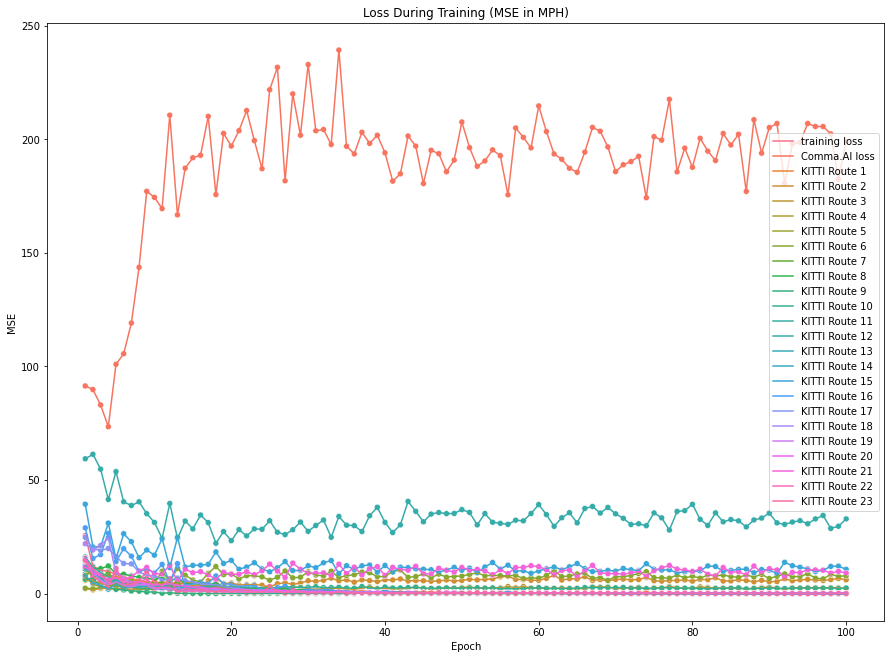

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 11))
def tmp():
  for key in history.keys():
    yield key, history[key]['training loss'], 'training loss'
    yield key, history[key]['Comma.AI loss'], 'Comma.AI loss'
    for i in range(1000):
      itm = 'KITTI loss {}'.format(i)
      if itm not in history[key].keys():
        break
      yield key, history[key][itm], 'KITTI Route {}'.format(i + 1)
x, y, c = zip(*tmp())
sns.lineplot(x=x, y=y, hue=c, ax=axs)
sns.scatterplot(x=x, y=y, hue=c, ax=axs, legend=False)
axs.set_title('Loss During Training (MSE in MPH)')
axs.set_xlabel('Epoch')
axs.set_ylabel('MSE')
plt.savefig('history.jpg')
plt.show()

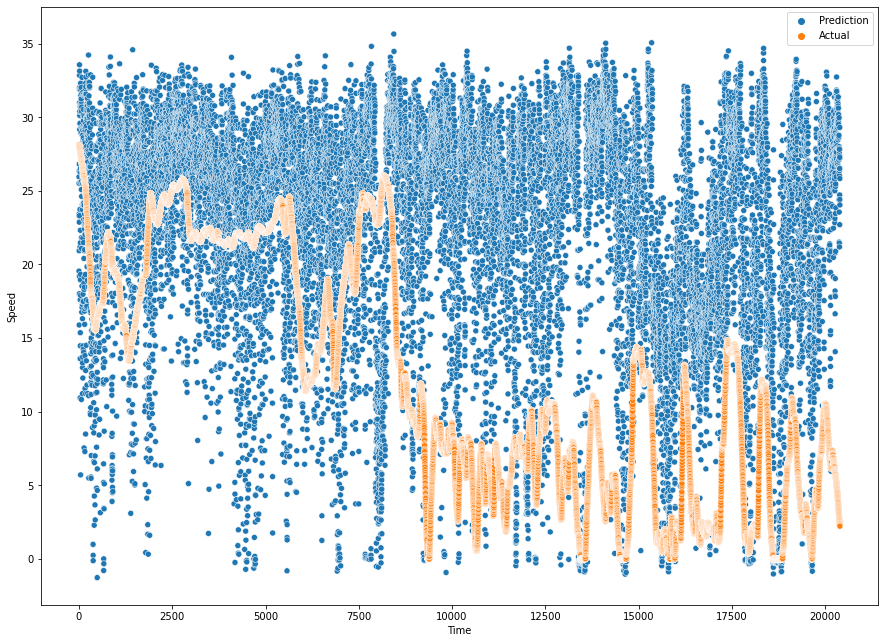

In [ ]:
data_loader = Dataset_Custom_Fast(comma_frames, comma_speeds)
data_loader = DataLoader(data_loader, batch_size=1, shuffle=False, drop_last=False)

model.eval()
pbar = tqdm(enumerate(data_loader), 'Making Predictions', total=len(data_loader), dynamic_ncols=True)
results = {
    'prediction':[],
    'actual':comma_speeds
}
for i, data in pbar:
  img, label = data
  if use_cuda:
    img.cuda()
    label.cuda()

  with torch.no_grad(): 
    #out = model(img, device)
    results['prediction'].insert(i, model(img, device) * FRAME_RATE_1/FRAME_RATE_2)

for i in tqdm(range(len(results['prediction'])), 'Converting'):
  results['prediction'][i] = results['prediction'][i].cpu().tolist()[0]

#format for display
def tmp():
  for i in range(len(results['prediction'])):
    yield i, results['prediction'][i], 'Prediction'
  for i in range(len(results['actual'])):
    yield i, results['actual'][i], 'Actual'
x, y, c = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=x, y=y, hue=c, ax=axs, legend=True)
#sns.lineplot(x=x, y=y, hue=c, ax=axs, legend=True)
axs.set_xlabel('Time')
axs.set_ylabel('Speed')
plt.savefig('comparison.jpg')
plt.show()

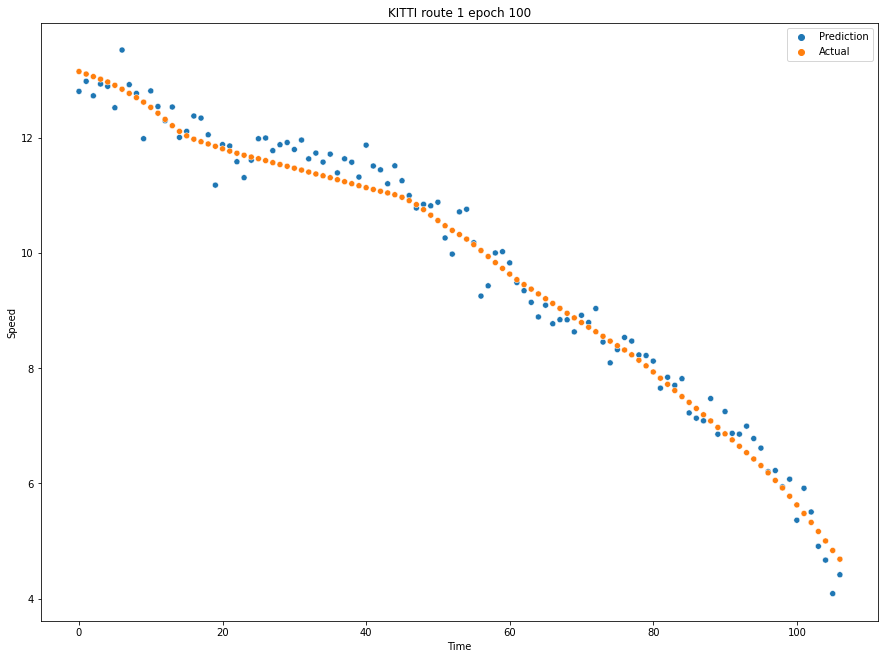

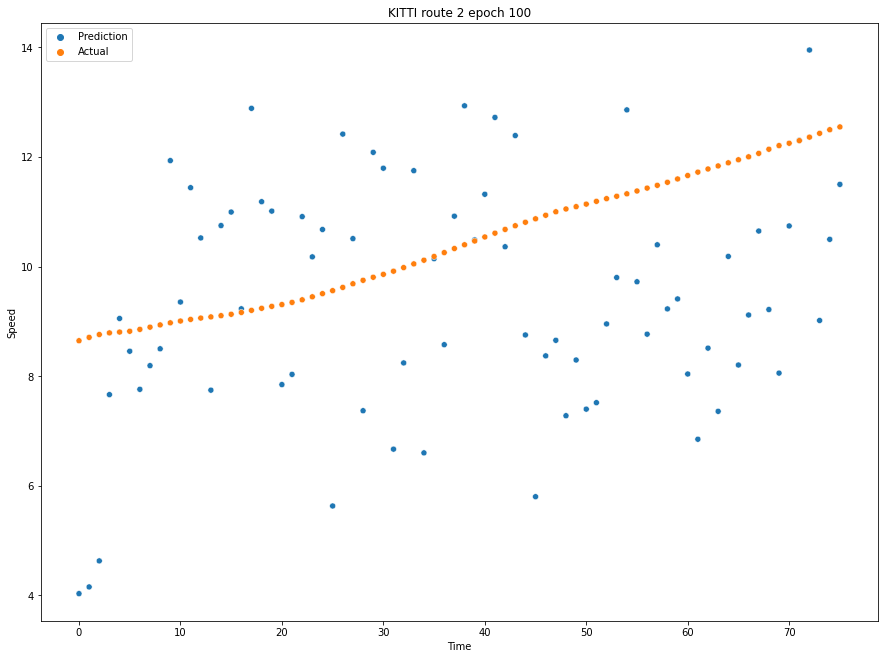

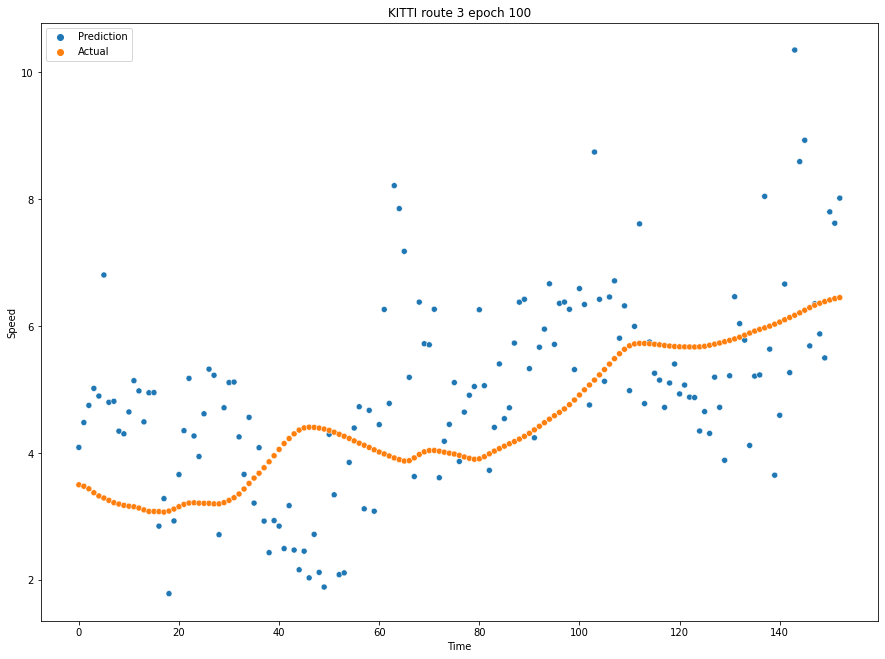

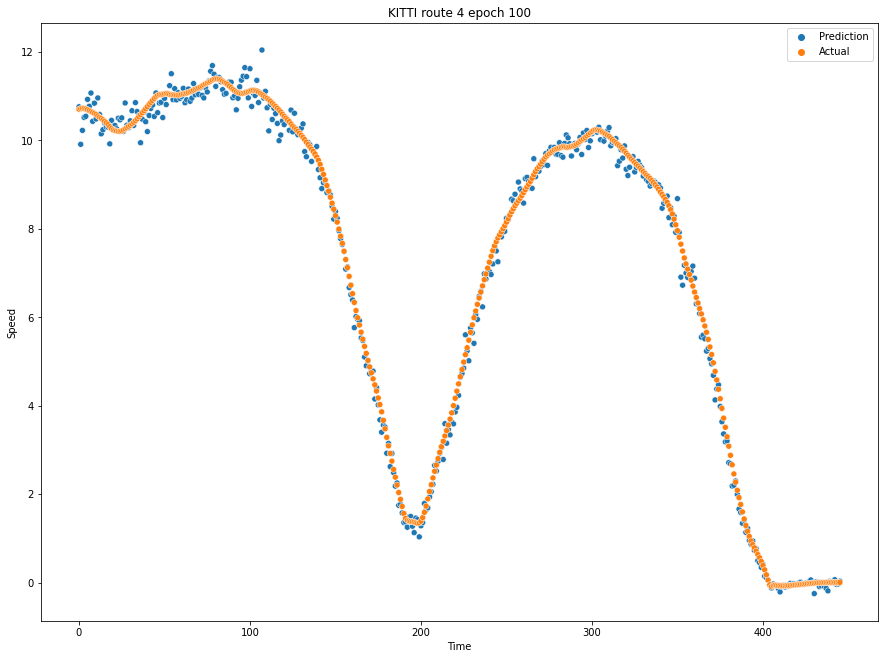

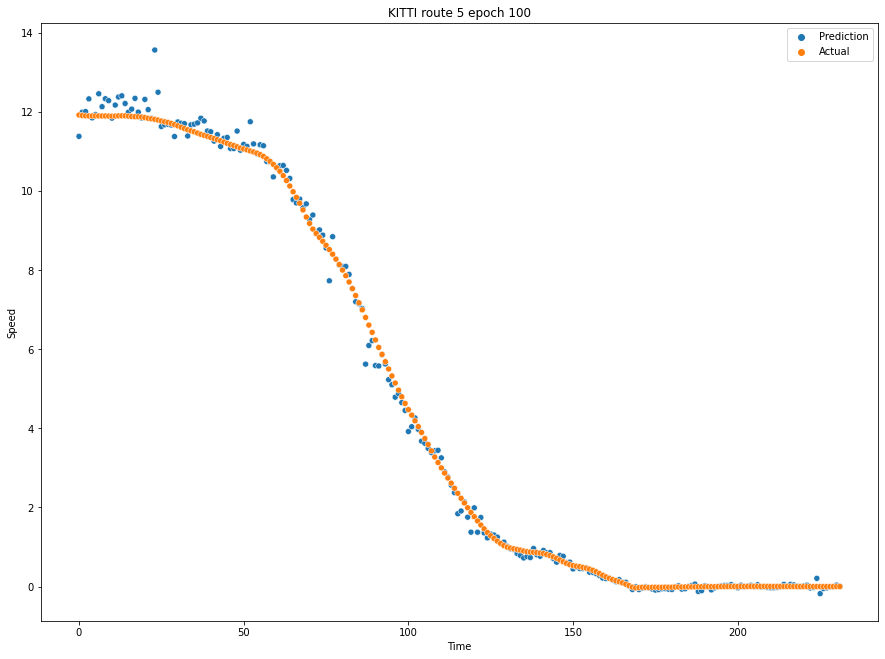

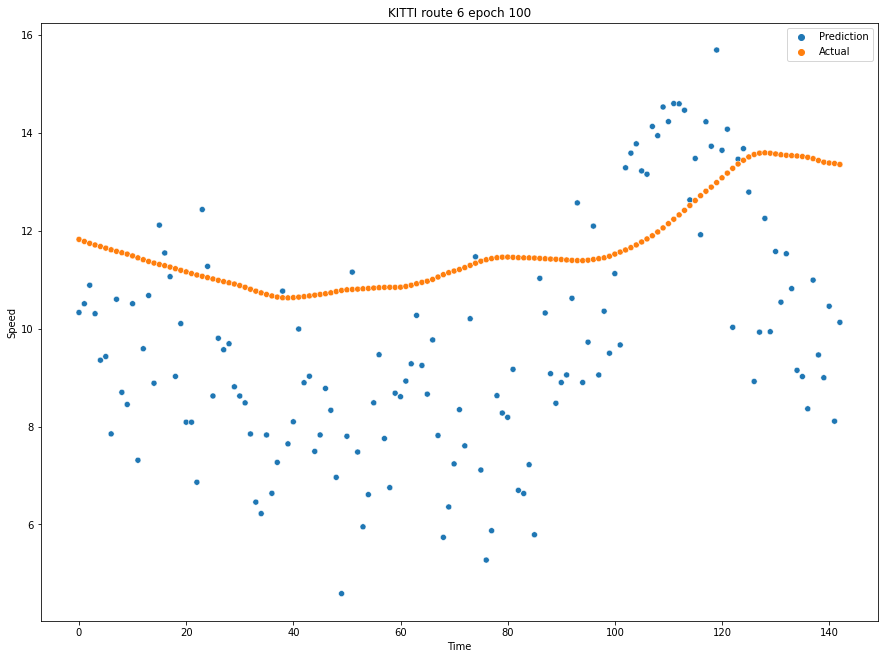

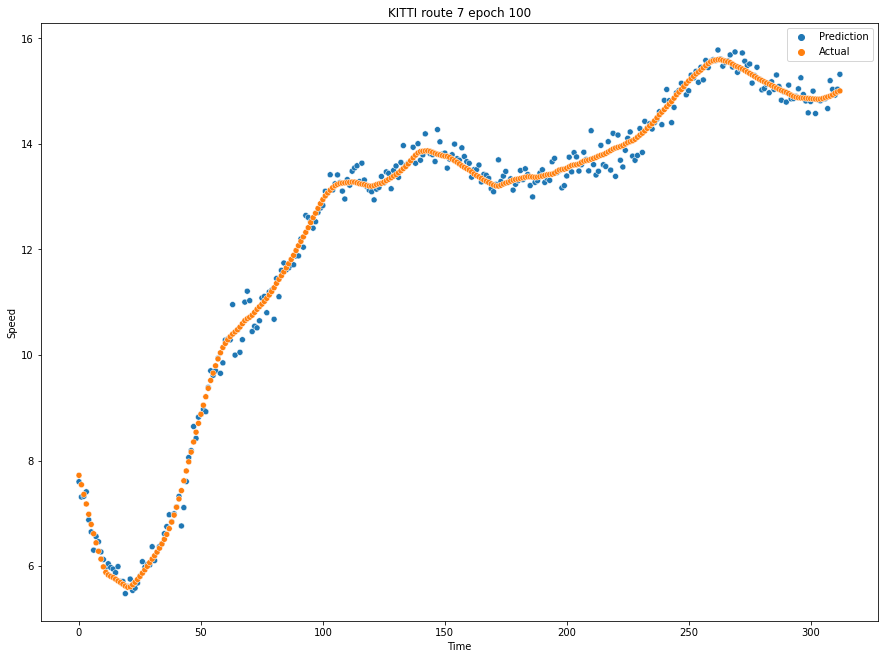

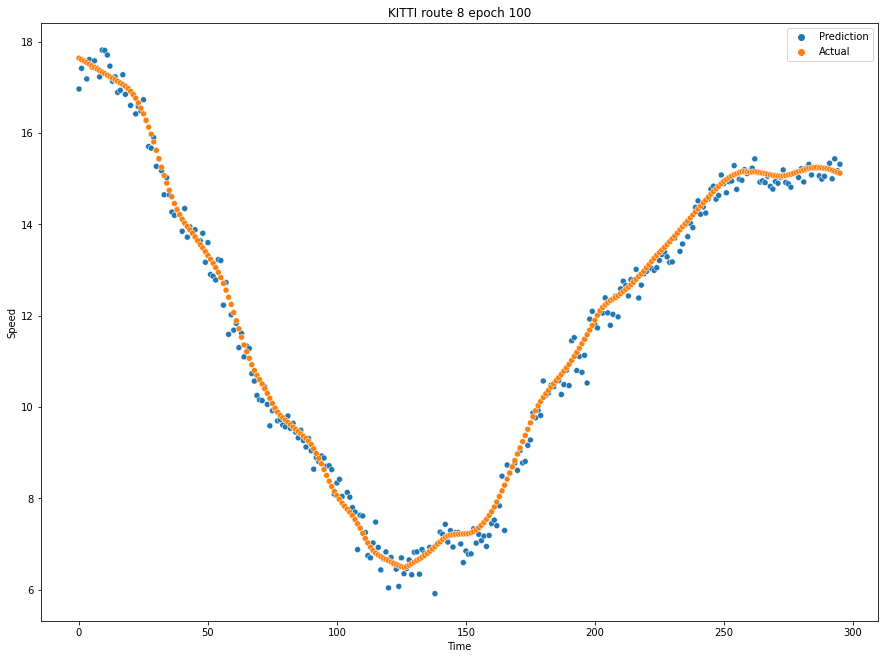

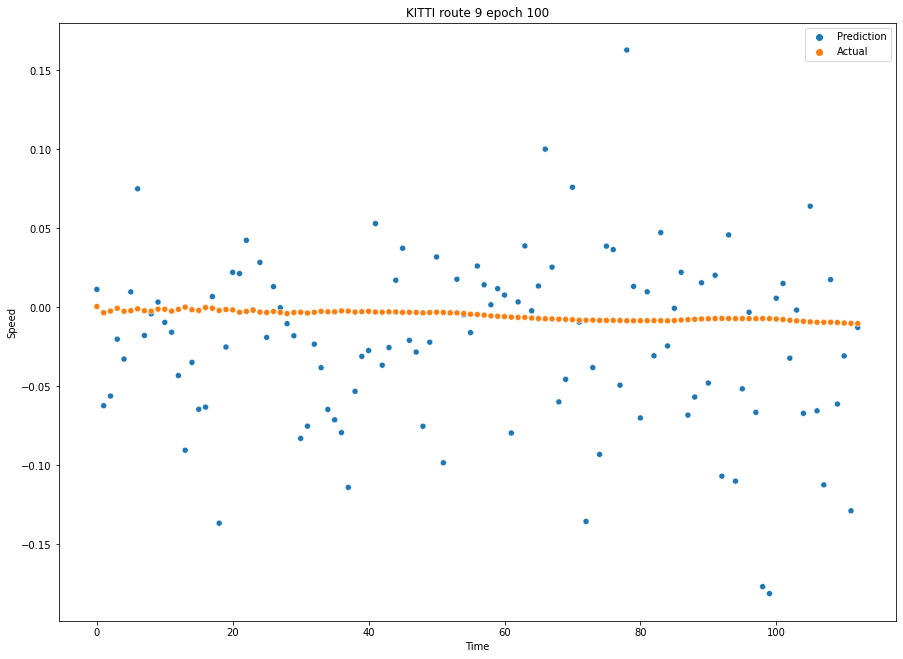

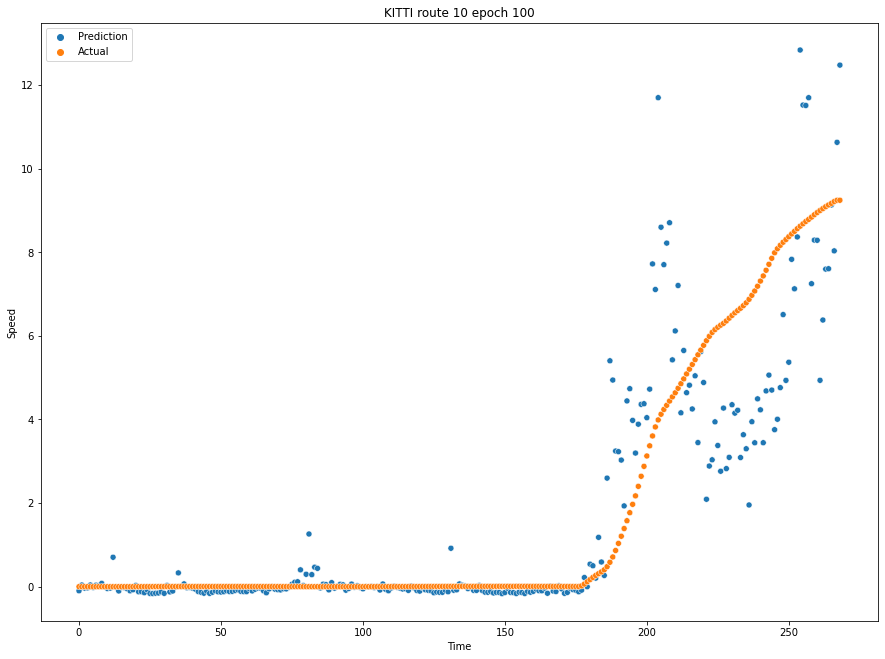

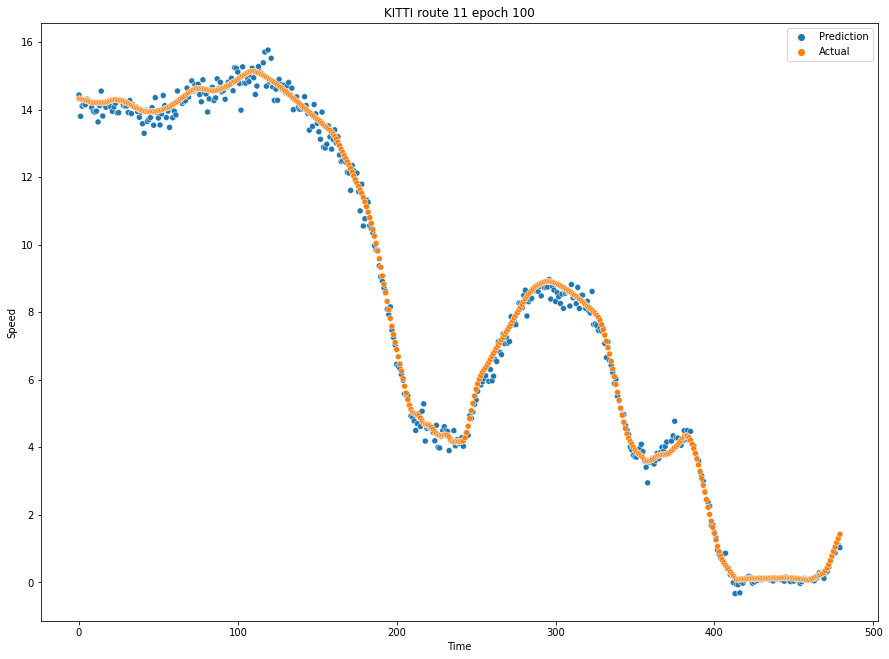

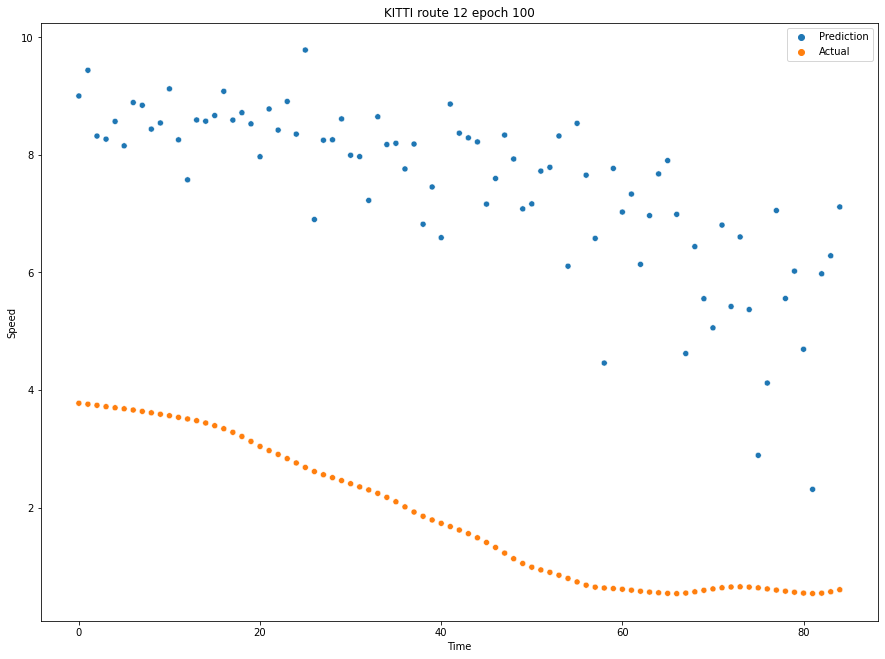

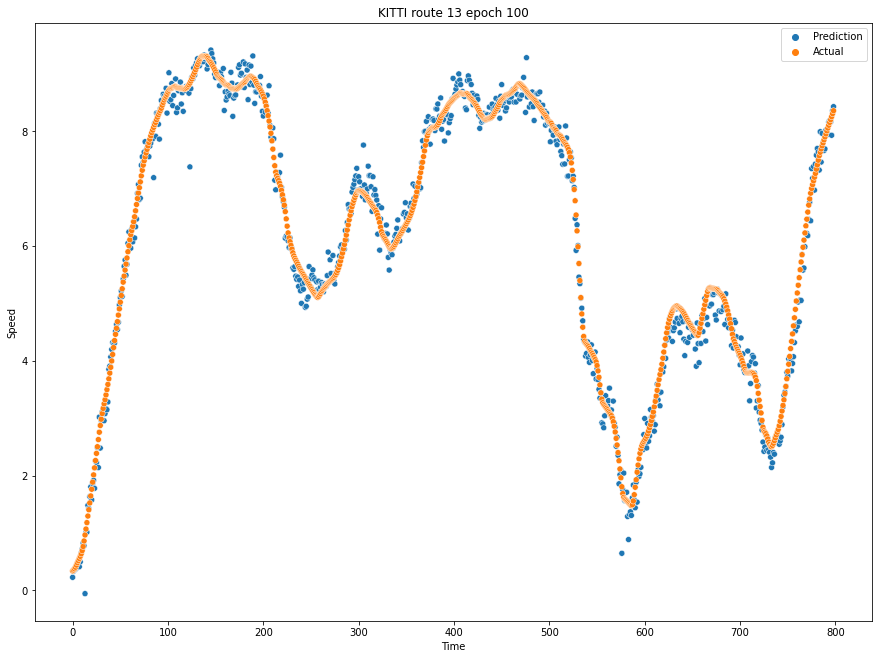

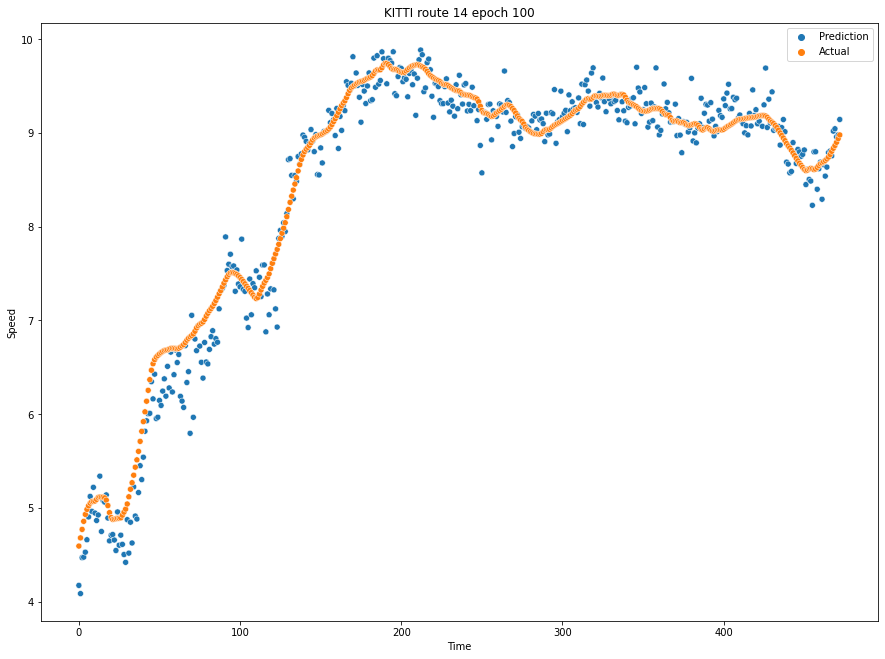

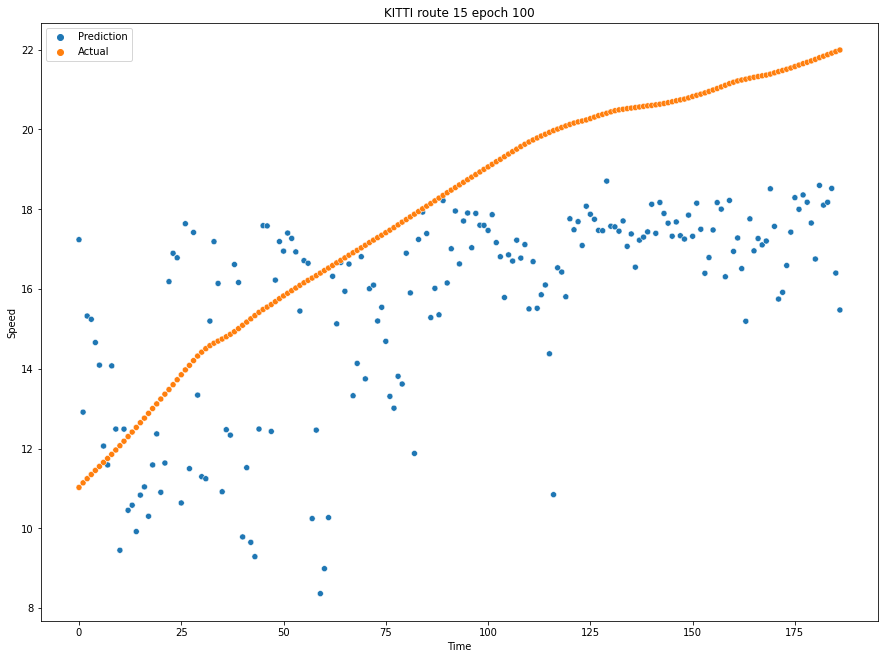

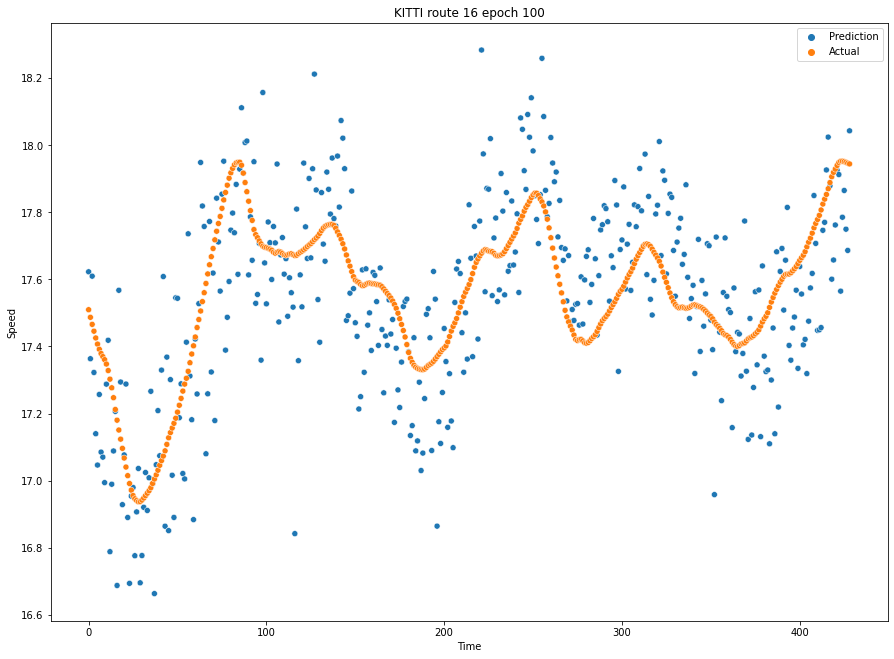

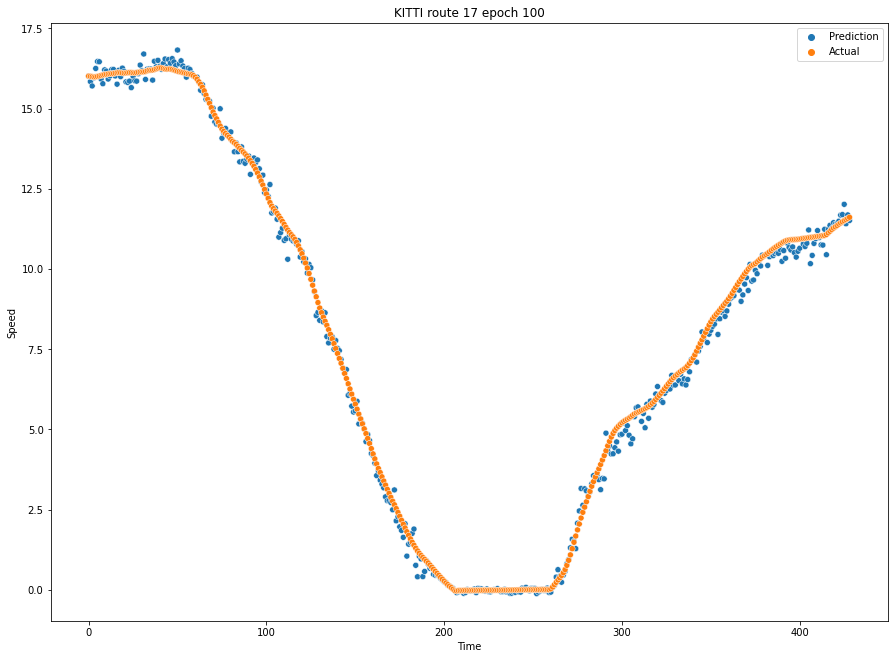

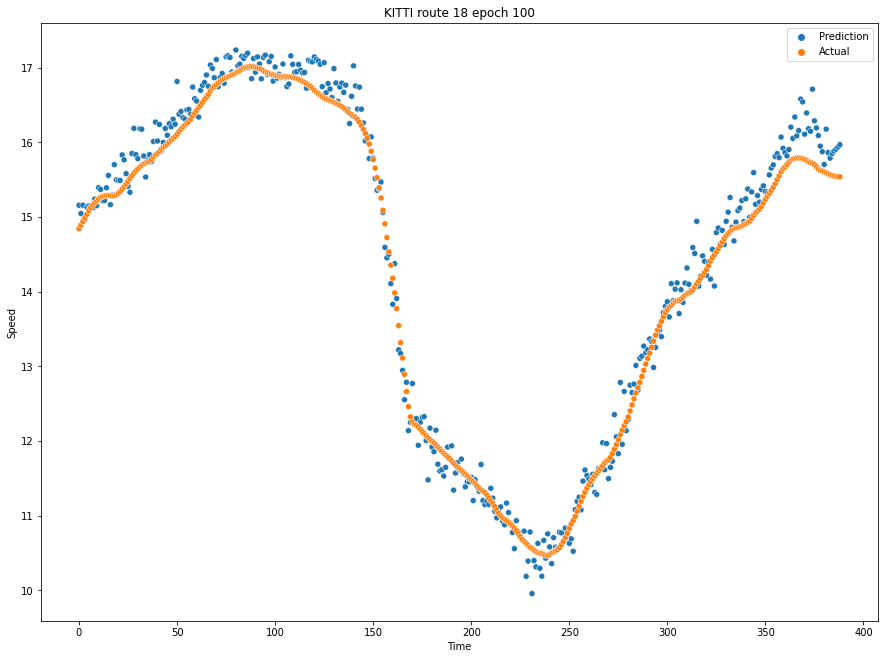

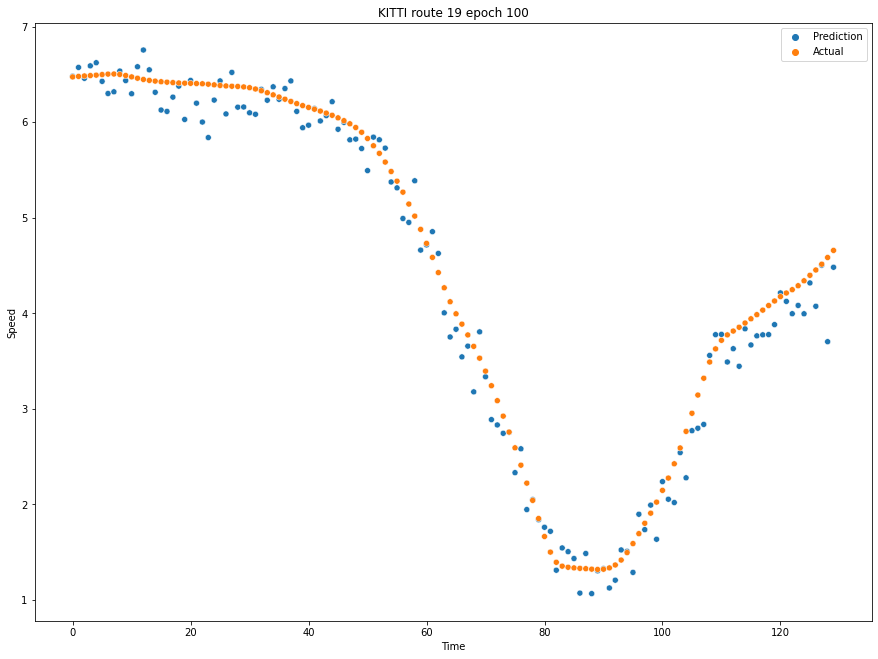

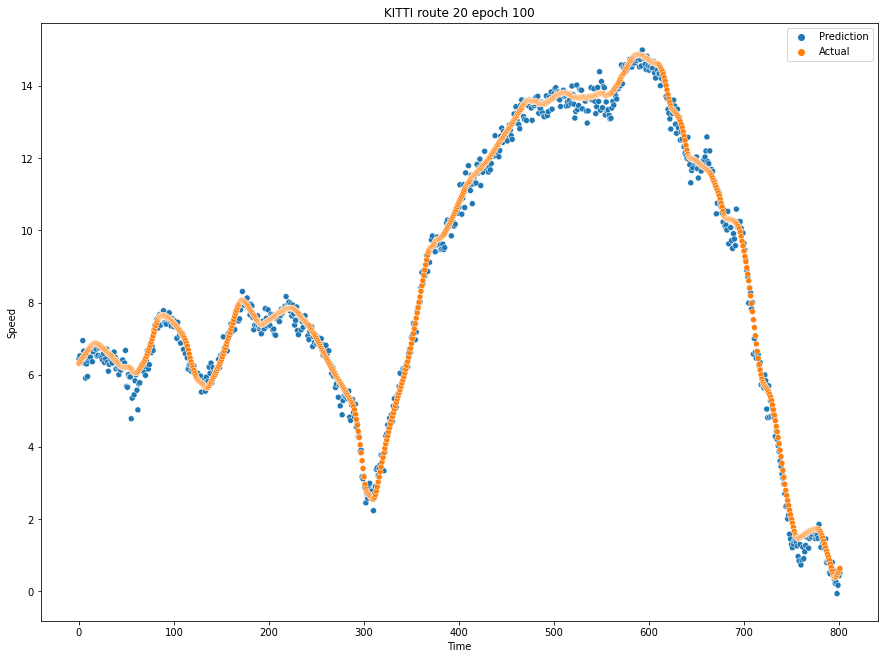

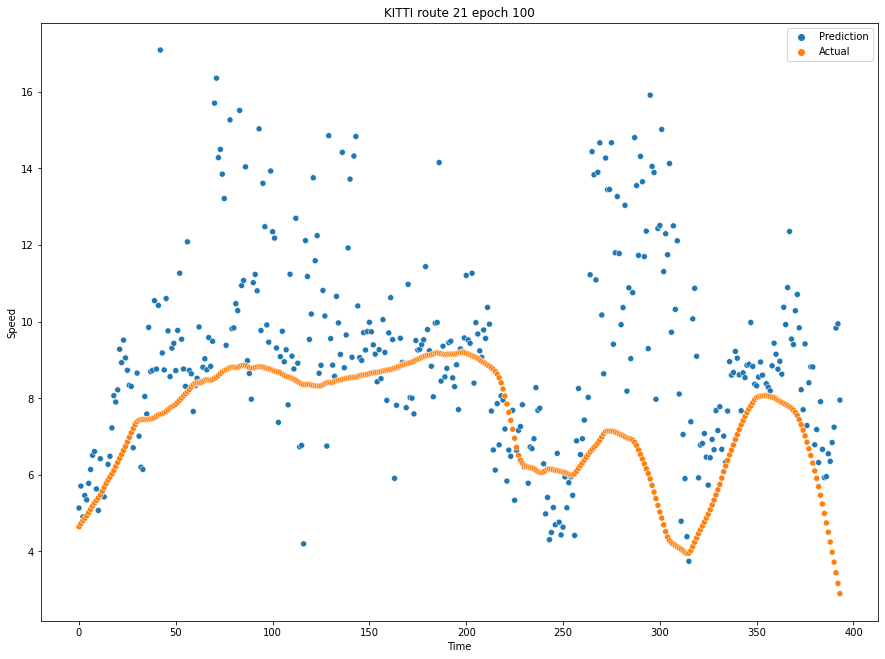

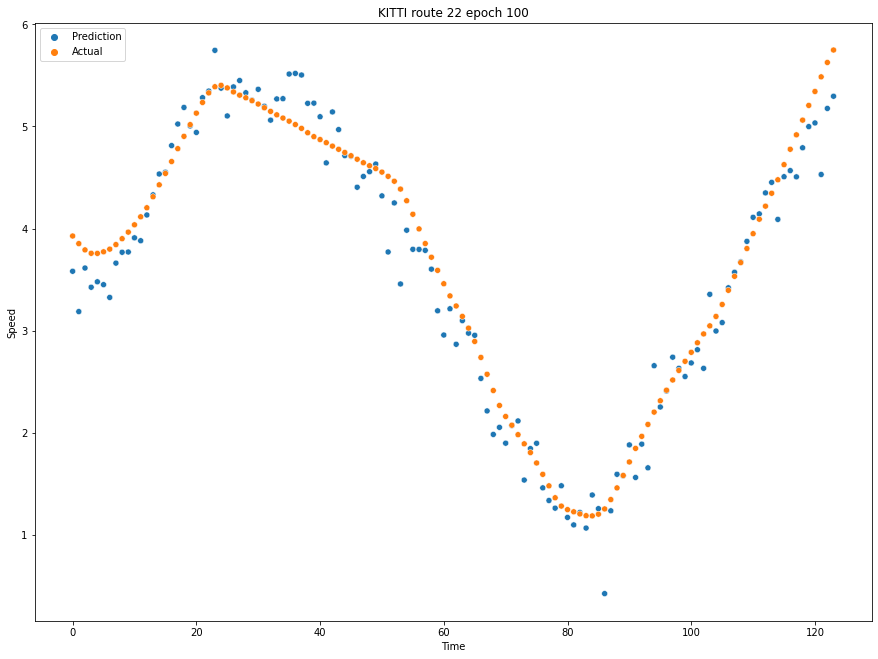

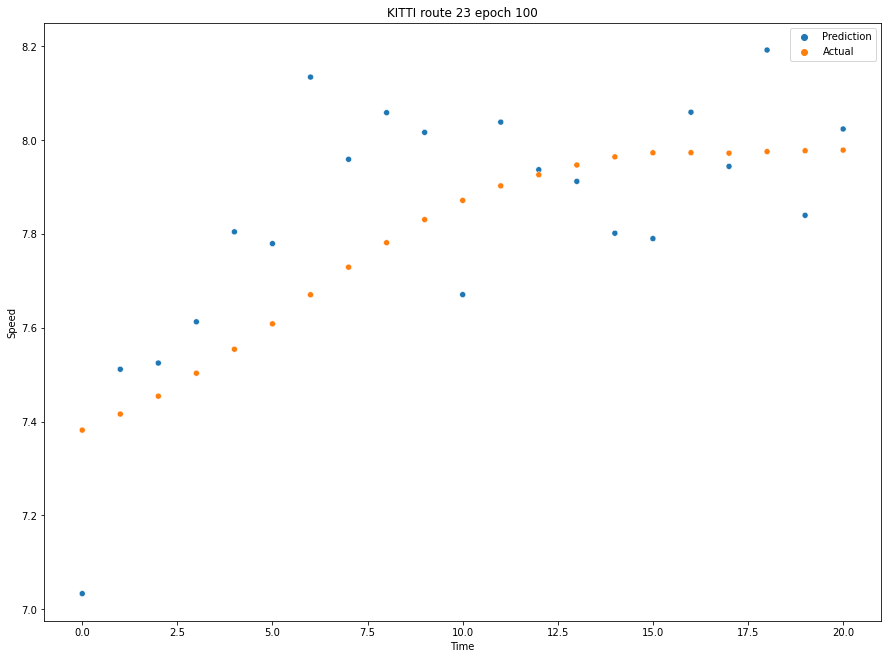

In [ ]:
for k in range(len(history) - 1, len(history), 10):
  model.load_state_dict(history[k + 1]['weights'])
  kitti_results = list()
  for j in range(len(kitti_frames)):
    data_loader = Dataset_Custom_Fast(kitti_frames[j], kitti_speeds[j])
    data_loader = DataLoader(data_loader, batch_size=1, shuffle=False, drop_last=False)

    model.eval()
    pbar = tqdm(enumerate(data_loader), 'Making Predictions', total=len(data_loader), dynamic_ncols=True)
    kitti_results.append({
        'prediction':[],
        'actual':kitti_speeds[j]
    })
    for i, data in pbar:
      img, label = data
      if use_cuda:
        img.cuda()
        label.cuda()

      with torch.no_grad(): 
        #out = model(img, device)
        kitti_results[j]['prediction'].insert(i, model(img, device))

    for i in tqdm(range(len(kitti_results[j]['prediction'])), 'Converting'):
      kitti_results[j]['prediction'][i] = kitti_results[j]['prediction'][i].cpu().tolist()[0]

    #format for display
    def tmp():
      for i in range(len(kitti_results[j]['prediction'])):
        yield i, kitti_results[j]['prediction'][i], 'Prediction'
      for i in range(len(kitti_results[j]['actual'])):
        yield i, kitti_results[j]['actual'][i], 'Actual'
    x, y, c = zip(*tmp())

    fig, axs = plt.subplots(1, 1, figsize=(15, 11))
    sns.scatterplot(x=x, y=y, hue=c, ax=axs, legend=True)
    #sns.lineplot(x=x, y=y, hue=c, ax=axs, legend=True)
    axs.set_title('KITTI route {} epoch {}'.format(j + 1, k + 1))
    axs.set_xlabel('Time')
    axs.set_ylabel('Speed')
    plt.savefig('comparison.jpg')
    plt.show()

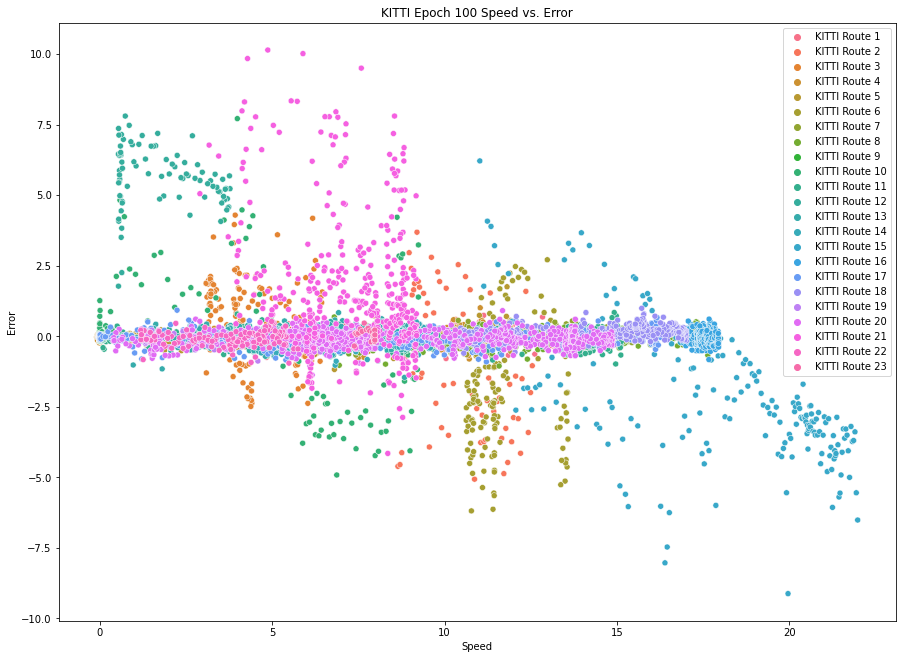

In [ ]:
for k in range(len(history) - 1, len(history), 10):
  #format for display
  def tmp():
    for j in range(len(kitti_frames)):
      for i in range(len(kitti_results[j]['prediction'])):
        yield kitti_results[j]['actual'][i], kitti_results[j]['prediction'][i] - kitti_results[j]['actual'][i], 'KITTI Route {}'.format(j + 1)
  x, y, c = zip(*tmp())

  fig, axs = plt.subplots(1, 1, figsize=(15, 11))
  sns.scatterplot(x=x, y=y, hue=c, ax=axs, legend=True)
  #sns.lineplot(x=x, y=y, hue=c, ax=axs, legend=True)
  axs.set_title('KITTI Epoch {} Speed vs. Error'.format(k + 1))
  axs.set_xlabel('Speed')
  axs.set_ylabel('Error')
  plt.show()

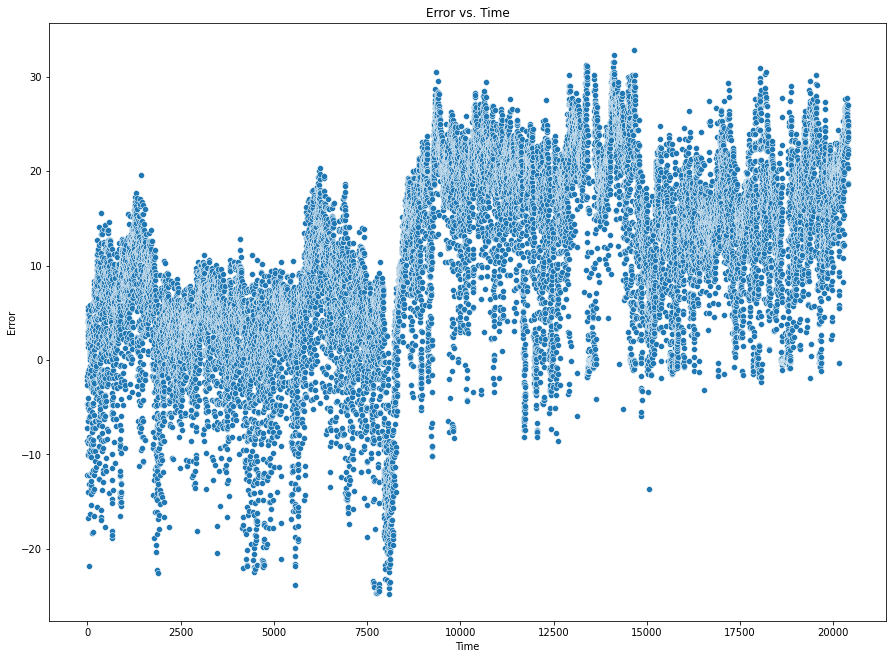

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield i, results['prediction'][i] - results['actual'][i]
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=t, y=err, ax=axs)
axs.set_xlabel('Time')
axs.set_ylabel('Error')
axs.set_title('Error vs. Time')
plt.show()

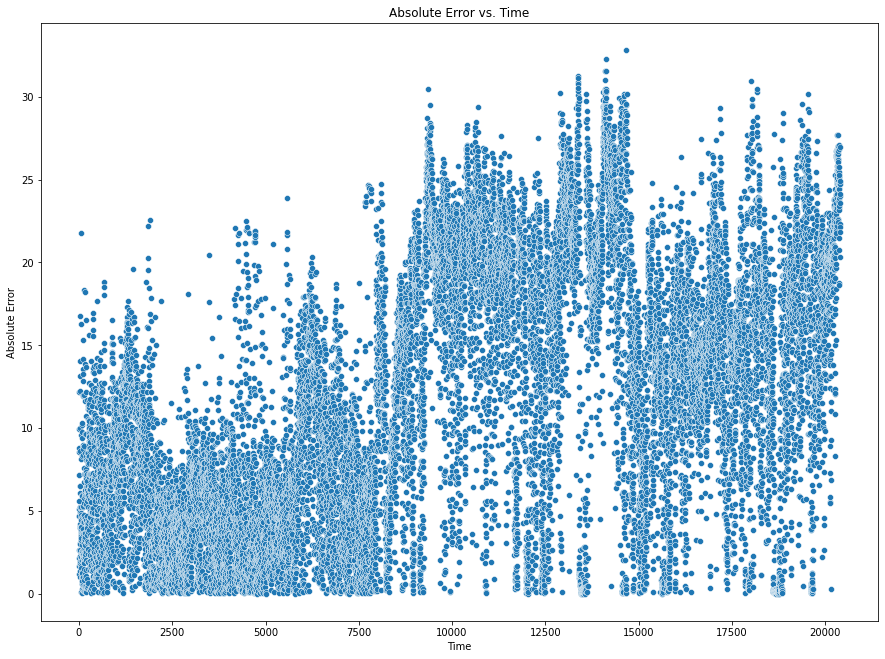

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield i, np.abs(results['prediction'][i] - results['actual'][i])
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=t, y=err, ax=axs)
axs.set_xlabel('Time')
axs.set_ylabel('Absolute Error')
axs.set_title('Absolute Error vs. Time')
plt.show()

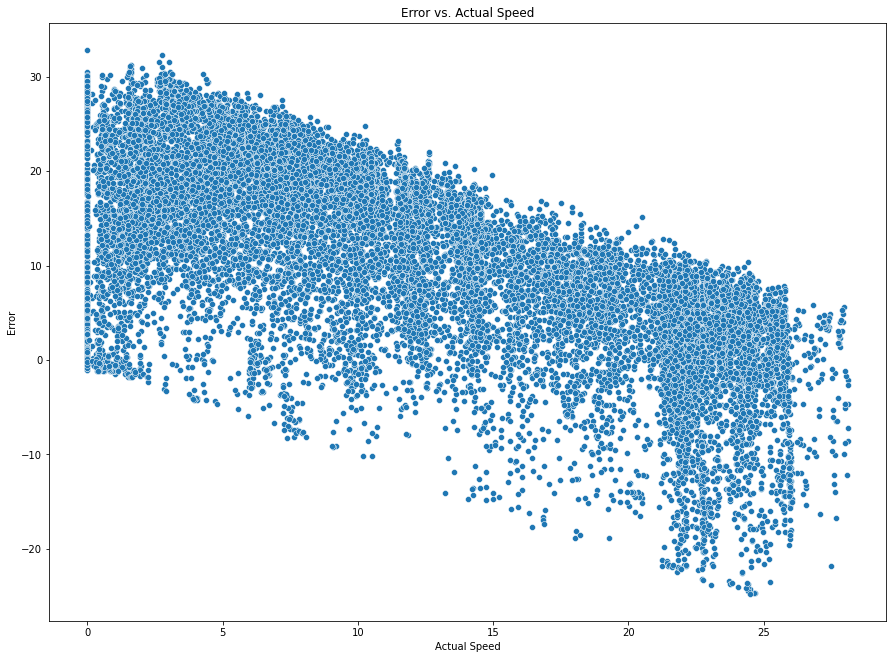

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield results['actual'][i], results['prediction'][i] - results['actual'][i]
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=t, y=err, ax=axs)
axs.set_xlabel('Actual Speed')
axs.set_ylabel('Error')
axs.set_title('Error vs. Actual Speed')
plt.show()

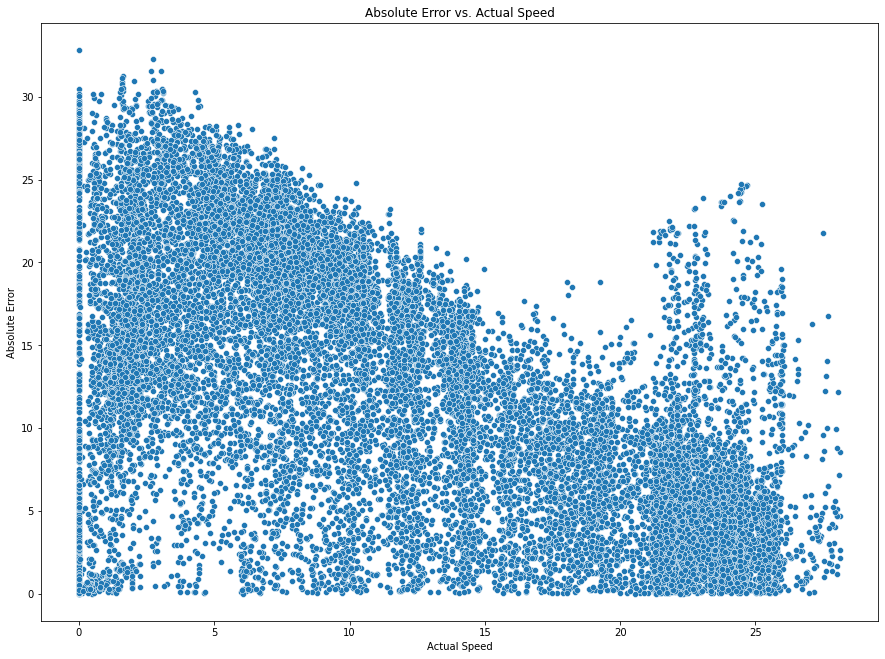

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield results['actual'][i], np.abs(results['prediction'][i] - results['actual'][i])
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.scatterplot(x=t, y=err, ax=axs)
axs.set_xlabel('Actual Speed')
axs.set_ylabel('Absolute Error')
axs.set_title('Absolute Error vs. Actual Speed')
plt.show()

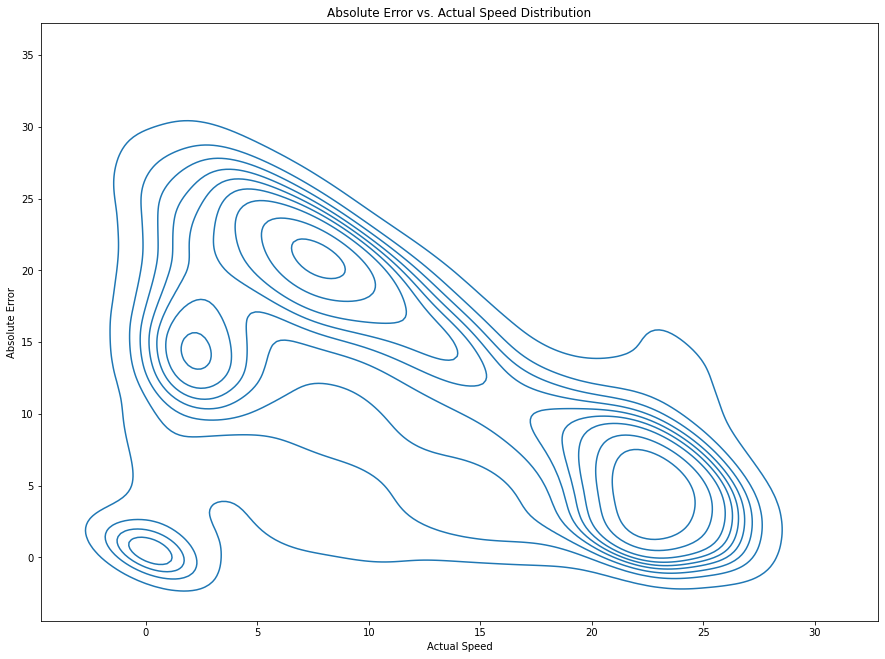

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield results['actual'][i], np.abs(results['prediction'][i] - results['actual'][i])
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.kdeplot(x=t, y=err, ax=axs)
axs.set_xlabel('Actual Speed')
axs.set_ylabel('Absolute Error')
axs.set_title('Absolute Error vs. Actual Speed Distribution')
plt.show()

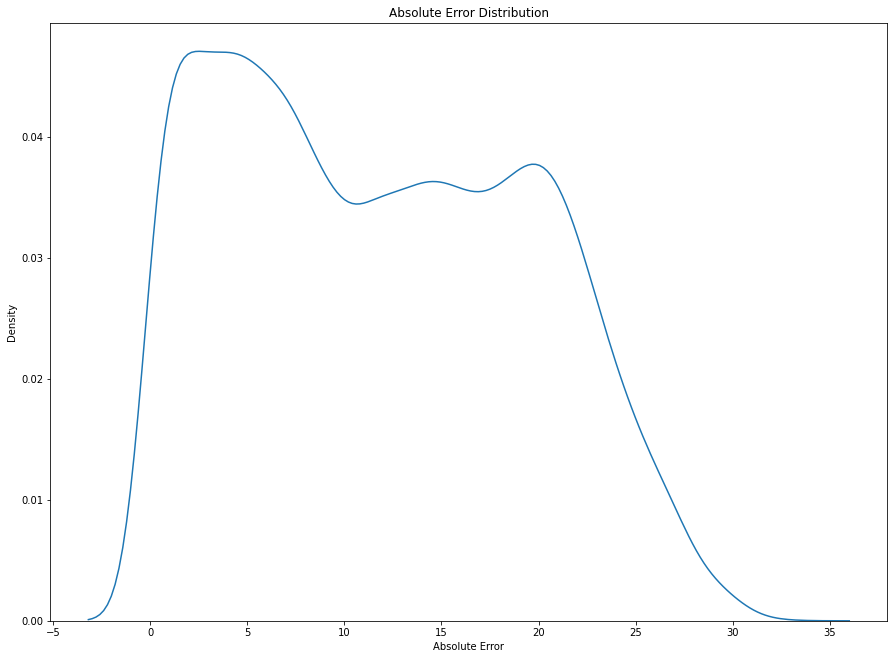

In [ ]:
def tmp():
  for i in range(len(results['prediction'])):
    yield results['actual'][i], np.abs(results['prediction'][i] - results['actual'][i])
t, err = zip(*tmp())

fig, axs = plt.subplots(1, 1, figsize=(15, 11))
sns.kdeplot(x=err, ax=axs)
#axs.set_xlabel('Actual Speed')
axs.set_xlabel('Absolute Error')
axs.set_title('Absolute Error Distribution')
plt.show()